# Bitcoin ATR indicator breakout strategy example

- Modified `bitcoin-breakout-atr`
- Instead of Binance data, use a the actual trading venue data feed on Uniswap v3 and Arbitrum
    - See changed `create_trading_universe` function
- In the cost structure, factor in 5 BPS fees in Uniswap v3, but not price impact
- As Arbitrum Uniswap v3 WBTC trading did not start until November 2022, we are capturing a different phase of the market 
  compared to the original backtest, and thus the strategy performance figures are different
  - Although absolute performance (CAGR) is lower than buy and hold Bitcoin, risk-adjusted returns are still better on the strategy 
- We are also seeing some of the DEX price effects where irregular DEX prices cause massive price spikes to either direction

# Set up

Set up Trading Strategy data client.


In [20]:
import os
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging
# 
client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


# Enable debug log if needed
if os.environ.get("LOG_LEVEL"):
    set_notebook_logging(os.environ["LOG_LEVEL"])


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [21]:
from tradingstrategy.chain import ChainId
import datetime

import pandas as pd

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "33-breakout-mainnet-big-coin-fast" # Used in cache paths

    chain_id = ChainId.ethereum
    exchanges = {"uniswap-v2", "uniswap-v3"}

    cycle_duration = CycleDuration.m15
    candle_time_bucket = TimeBucket.m15 
    allocation = 0.20  # Allocate max 20% of cash on a single position

    atr_length = 10
    fract = 3.5

    adx_length = 0  # 14 days
    adx_threshold = 0

    ema_length = 0  # pd.Timedelta("90d") // candle_time_bucket.to_timedelta()
    roc_length = 0
    roc_threshold = 0
        
    trailing_stop_loss_pct = 0.98
    trailing_stop_loss_activation_level = 1.07
    stop_loss_pct = 0.98 

    # Volatility binning filter
    vol_bin_filter = {0.00}
    vol_bin_filter_lookback = 200
    daily_atr_length = 60
    vol_bin_level_1_threshold = 0.25
    vol_bin_level_3_threshold = 0.75

    # For the trading pair inclusion criteria
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_volatility_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    tvl_ewm_span = 7 * 24  # Smooth TVL inclusin criteria
    min_volume = 25_000
    min_tvl_prefilter = 10_000_000  # USD - to reduce number of trading pairs for backtest-purposes onl
    min_tvl = 5_000_000
    min_token_sniffer_score = 20  # 20 = AAVE    

    #
    # Size risk
    #
    per_position_cap_of_pool = 0.005
    min_position_size = 100.00  # USD

    #
    # Live trading only
    #

    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = datetime.timedelta(hours=200)

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2020, 9, 1)
    backtest_end = datetime.datetime(2025, 4, 1)
    stop_loss_time_bucket = TimeBucket.m15
    initial_cash = 10_000



parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

from tradeexecutor.strategy.parameters import display_parameters
display_parameters(parameters)


Value  \
Name                                                                     
adx_length                                                           0   
adx_threshold                                                        0   
allocation                                                         0.2   
atr_length                                                          10   
backtest_end                                       2025-04-01 00:00:00   
backtest_start                                     2020-09-01 00:00:00   
candle_time_bucket                                      TimeBucket.m15   
chain_id                                                             1   
cycle_duration                                 CycleDuration.cycle_15m   
daily_atr_length                                                    60   
ema_length                                                           0   
exchanges                                     {uniswap-v2, uniswap-v3}   
fract                                                              3.5   
id                                   33-breakout-mainnet-big-coin-fast   
initial_cash                                                     10000   
min_position_size                                                100.0   
min_token_sniffer_score                                             20   
min_tvl                                                        5000000   
min_tvl_prefilter                                             10000000   
min_volume                                                       25000   
per_position_cap_of_pool                                         0.005   
required_history_period                                8 days, 8:00:00   
roc_length                                                           0   
roc_threshold                                                        0   
rolling_volatility_bars                                            672   
rolling_volume_bars                                                672   
routing                                           TradeRouting.default   
stop_loss_pct                                                     0.98   
stop_loss_time_bucket                                   TimeBucket.m15   
trailing_stop_loss_activation_level                               1.07   
trailing_stop_loss_pct                                            0.98   
tvl_ewm_span                                                       168   
vol_bin_filter                                                   {0.0}   
vol_bin_filter_lookback                                            200   
vol_bin_level_1_threshold                                         0.25   
vol_bin_level_3_threshold                                         0.75   
grid_search                                                      False   

                                              Type  
Name                                                
adx_length                                     int  
adx_threshold                                  int  
allocation                                   float  
atr_length                                     int  
backtest_end                              datetime  
backtest_start                            datetime  
candle_time_bucket                      TimeBucket  
chain_id                                   ChainId  
cycle_duration                       CycleDuration  
daily_atr_length                               int  
ema_length                                     int  
exchanges                                      set  
fract                                        float  
id                                             str  
initial_cash                                   int  
min_position_size                            float  
min_token_sniffer_score                        int  
min_tvl                                        int  
min_tvl_prefilter                              int  
min_volume                                     int  
per_position

# Chain configuration

- Configure different chain parameters
- Allows us to hop between different chains easily in the same notebook

In [22]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.lending import LendingProtocolType


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
        "cbBTC"
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v2", "WETH", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "AAVE",
        "WETH",
        "WBTC",
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.binance:
    SUPPORTING_PAIRS = [
        (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
        (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WBNB",
        "FTC",
        "TRUNK",
        "CUMMIES",
    ]

    VOL_PAIR = (Parameters.chain_id, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

    LENDING_RESERVES = None

    PREFERRED_STABLECOIN = USDT_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.avalanche:
    SUPPORTING_PAIRS = [
        (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030),  
        (ChainId.avalanche, "trader-joe", "WETH.e", "WAVAX", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WAVAX",
        "JOE",
        "WETH.e",
    ]

    VOL_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030)

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

    LENDING_RESERVES = None    

else:
    raise NotImplementedError(f"Chain not supported: {parameters.chain_id}")

# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use onchain DEX data. But if you would like to use Binance CEX for a longer history to backtest, uncomment the second cell below

In [23]:
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    if execution_context.live_trading:
        # Live trading, send strategy universe formation details 
        # to logs
        debug_printer = logger.info
    else:    
        # Notebook node
        debug_printer = print

    chain_id = Parameters.chain_id

    debug_printer(f"Preparing trading universe on chain {chain_id.get_name()}")

    exchange_universe = client.fetch_exchange_universe()
    targeted_exchanges = [exchange_universe.get_by_chain_and_slug(chain_id, slug) for slug in Parameters.exchanges]
    
    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    all_pairs_df = filter_for_exchange_slugs(all_pairs_df, Parameters.exchanges)
    debug_printer("Creating universe for benchmark pair extraction")
    pair_universe = PandasPairUniverse(
        all_pairs_df, 
        exchange_universe=exchange_universe,
        build_index=False,
    )
    debug_printer(f"Exchanges {Parameters.exchanges} have total {len(all_pairs_df):,} pairs on chain {Parameters.chain_id.get_name()}")

    # Get TVL data for prefilteirng
    if execution_context.live_trading:
        # For live trading, we take TVL data from ~around the start of the strategy until today
        tvl_time_bucket = TimeBucket.d1
        start = datetime.datetime(2024, 2, 1)
        end = tvl_time_bucket.floor(pd.Timestamp(datetime.datetime.utcnow() - tvl_time_bucket.to_timedelta()))
    else:
        start = Parameters.backtest_start
        end = Parameters.backtest_end

    #
    # Do exchange and TVL prefilter pass for the trading universe
    #
    min_tvl = Parameters.min_tvl_prefilter
    # logging.getLogger().setLevel(logging.INFO)
    liquidity_time_bucket = TimeBucket.d1
    tvl_df = client.fetch_tvl(
        mode="min_tvl_low",
        bucket=liquidity_time_bucket,
        start_time=start,
        end_time=end,
        exchange_ids=[exc.exchange_id for exc in targeted_exchanges],
        min_tvl=min_tvl,
    )
    # logging.getLogger().setLevel(logging.WARNING)
    debug_printer(f"Fetch TVL, we got {len(tvl_df['pair_id'].unique())} pairs with TVL data for min TVL criteria {min_tvl}")

    tvl_filtered_pair_ids = tvl_df["pair_id"].unique()
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]
    needed_pair_ids = set(benchmark_pair_ids) | set(tvl_filtered_pair_ids)
    pairs_df = all_pairs_df[all_pairs_df["pair_id"].isin(needed_pair_ids)]
    debug_printer(f"After TVL prefilter to {Parameters.min_tvl_prefilter:,} in {Parameters.backtest_start} - {Parameters.backtest_end}, we have {len(pairs_df)} trading pairs")
    pairs_df = add_base_quote_address_columns(pairs_df)

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    allowed_quotes = {
        PREFERRED_STABLECOIN,
        # WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }
    filtered_pairs_df = filter_pairs_default(
        pairs_df,
        good_quote_token_addresses=allowed_quotes,
        verbose_print=print,
    )

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(filtered_pairs_df)

    # Get our reference pairs back to the dataset
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')
    debug_printer(f"After deduplication we have {len(pairs_df)} pairs")

    # Add benchmark pairs back to the dataset
    pairs_df = pd.concat([pairs_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Load metadata
    debug_printer("Loading metadata")
    # logging.getLogger().setLevel(logging.INFO)
    pairs_df = load_token_metadata(pairs_df, client, printer=debug_printer)
    # logging.getLogger().setLevel(logging.WARNING)

    # Scam filter using TokenSniffer
    risk_filtered_pairs_df = filter_by_token_sniffer_score(
        pairs_df,
        risk_score=Parameters.min_token_sniffer_score,
        printer=debug_printer,
    )

    # Check if we accidentally get rid of benchmark pairs we need for the strategy
    difference = set(benchmark_pair_ids).difference(set(risk_filtered_pairs_df["pair_id"]))
    if difference:
        first_dropped_id = next(iter(difference))
        first_dropped_data = pairs_df.loc[pairs_df.pair_id == first_dropped_id]
        assert len(first_dropped_data) == 1, f"Got {len(first_dropped_data)} entries: {first_dropped_data}"
        raise AssertionError(f"Benchmark trading pair dropped in filter_by_token_sniffer_score() check: {first_dropped_data.iloc[0]}")
    pairs_df = risk_filtered_pairs_df.sort_values("volume", ascending=False)
    debug_printer(f"After TokenSniffer risk filter we have {len(pairs_df)} pairs")

    # Remove extra pairs from the TVL data,
    # so we do not drag extra data and memory usage to the trading universe and liquidity candles
    tvl_pair_count_no_filtering = tvl_df["pair_id"].nunique()
    tvl_df = tvl_df[tvl_df["pair_id"].isin(pairs_df["pair_id"])]
    tvl_filtering_count = tvl_df["pair_id"].nunique()
    debug_printer(f"TVL data before risk filtering had {tvl_pair_count_no_filtering} pairs, after filtering we have {tvl_filtering_count} pairs")

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    other_dex = pairs_df.loc[~((pairs_df["exchange_slug"] != "uniswap-v3") | (pairs_df["exchange_slug"] != "uniswap-v2"))]
    debug_printer(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}, other DEX: {len(other_dex)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity_time_bucket=liquidity_time_bucket,
        preloaded_tvl_df=tvl_df,
        lending_reserves=LENDING_RESERVES,    
        stop_loss_time_bucket=Parameters.stop_loss_time_bucket
    )

    reserve_asset = PREFERRED_STABLECOIN

    debug_printer("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    debug_printer(f"Total {strategy_universe.get_pair_count()}")

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
)


Preparing trading universe on chain Ethereum
Creating universe for benchmark pair extraction
Exchanges {'uniswap-v2', 'uniswap-v3'} have total 150,870 pairs on chain Ethereum
Fetch TVL, we got 229 pairs with TVL data for min TVL criteria 10000000
After TVL prefilter to 10,000,000 in 2020-09-01 00:00:00 - 2025-04-01 00:00:00, we have 229 trading pairs
Pairs in the input dataset 229
Pairs having a good fee 229
Pairs that are not stable-stable 216
Pairs that are not derivative tokens 210
Pairs that are not rebase tokens 210
Pairs with good quote token 18
Pairs with clean ASCII token name 18
After deduplication we have 16 pairs
Loading metadata
Loading metadata for 16 base tokens in 16 trading pairs
Got data back for 16 tokens
TokenSniffer has 0 error entries
filter_by_token_sniffer_score(): total 16, missing metadata 0, missing TokenSniffer data 0, TokenSniffer error'ed: 0
Filtered by TokenSniffer risk score: 20, before: 16, after NA: 16, after risk score: 15, entries below threshold: 1, 

Creating trading universe
Total 15
Universe creation done


base quote    exchange  fee %   type:     price    last_price_at  \
id                                                                           
2697762  1INCH  USDC  uniswap-v3   1.00  traded      0.16 15 days 14:45:00   
76561     ASTO  USDC  uniswap-v2   0.30  traded      0.01 15 days 14:45:00   
19690     BOND  USDC  uniswap-v2   0.30  traded      0.25 15 days 14:45:00   
26333      DSD  USDC  uniswap-v2   0.30  traded      0.00 15 days 14:45:00   
6088       ESD  USDC  uniswap-v2   0.30  traded      0.00 15 days 14:45:00   
7707      FARM  USDC  uniswap-v2   0.30  traded     30.67 15 days 14:45:00   
58914      GRO  USDC  uniswap-v2   0.30  traded      0.03 15 days 14:45:00   
61         HEX  USDC  uniswap-v2   0.30  traded      0.00 15 days 14:45:00   
31043     PUSD  USDC  uniswap-v2   0.30  traded      0.00 15 days 14:45:00   
34828      RAD  USDC  uniswap-v2   0.30  traded      0.76 15 days 14:45:00   
2697647   WBTC  USDC  uniswap-v3   0.30  traded  82473.68 15 days 14:45:00   
2697765   WETH  USDC  uniswap-v3   0.05  traded   1822.98 15 days 14:45:00   
1         WETH  USDC  uniswap-v2   0.30  traded   1825.40 15 days 14:45:00   
24194     eXRD  USDC  uniswap-v2   0.30  traded      0.01 15 days 14:45:00   
4364121     wM  USDC  uniswap-v3   0.01  traded      1.00 15 days 14:45:00   

             first_price_at        volume         tvl  tvl_at          tax  
id                                                                          
2697762 2021-05-06 05:00:00  0.000000e+00      17,535 15 days  0.0% / 0.0%  
76561   2022-04-06 23:45:00  0.000000e+00     576,224 15 days        - / -  
19690   2020-10-26 00:00:00  0.000000e+00      37,889 15 days        - / -  
26333   2020-11-27 14:45:00  0.000000e+00         102 15 days        - / -  
6088    2020-09-01 04:15:00  0.000000e+00      12,872 15 days        - / -  
7707    2020-09-01 18:45:00  2.253445e+00      15,190 15 days        - / -  
58914   2021-10-01 09:15:00  0.000000e+00      18,926 15 days        - / -  
61      2020-09-04 07:00:00  3.281452e+01      43,998 15 days        - / -  
31043   2021-01-07 08:45:00  0.000000e+00         549 15 days        - / -  
34828   2021-03-18 09:45:00  7.320467e+02   1,603,829 15 days        - / -  
2697647 2021-05-06 05:00:00  0.000000e+00  53,599,808 15 days  0.0% / 0.0%  
2697765 2021-05-06 04:45:00  1.164668e+06  67,349,655 15 days  0.0% / 0.0%  
1       2020-09-01 00:00:00  6.740195e+03   9,727,683 15 days        - / -  
24194   2020-11-17 16:30:00  0.000000e+00     197,801 15 days        - / -  
4364121 2024-09-07 17:00:00  0.000000e+00  20,114,072 15 days  0.0% / 0.0%

# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk

In [ ]:
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.analysis.indicator import display_indicators
from tradeexecutor.state.identifier import TradingPairIdentifier
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline


indicators = IndicatorRegistry()


empty_series = pd.Series([], index=pd.DatetimeIndex([]))
empty_ohlcv_df = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'], index=pd.DatetimeIndex([]))


@indicators.define(source=IndicatorSource.ohlcv)
def atr(open, high, low, close, atr_length) -> pd.Series:
    """Calculate ATR."""    
    atr = pandas_ta.atr(
        close=close,
        open=open,
        high=high,
        low=low,
        length=atr_length,
    )
    return atr



@indicators.define(source=IndicatorSource.close_price)
def ema(close, ema_length) -> pd.Series:
    """Calculate filtering moving average."""    
    ema = pandas_ta.sma(
        close,
        length=ema_length,
    )

    if ema is None:
        return empty_series

    return ema


@indicators.define(source=IndicatorSource.close_price)
def roc(close, roc_length) -> pd.Series:
    """Calculate filtering moving average."""    
    
    roc = pandas_ta.roc(
        close,
        length=roc_length,
    )

    if roc is None:
        return empty_series

    return roc    





@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close, pair: TradingPairIdentifier) -> pd.DataFrame:
    """Resample pricees to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    assert isinstance(daily_df, pd.DataFrame)
    assert len(daily_df.columns) > 1
    return daily_df


@indicators.define(dependencies=(daily_price,), source=IndicatorSource.dependencies_only_per_pair)
def daily_adx(
    adx_length, 
    dependency_resolver: IndicatorDependencyResolver, 
    pair: TradingPairIdentifier
):
    daily_df = dependency_resolver.get_indicator_data(
        "daily_price",
        parameters={},
        pair=pair,
        column="all"
    )    

    if len(daily_df) == 0:
        # Some pairs with missing data do not get called for daily_price()
        # and they get empty pd.Series here, so we just pass through "no daily price data" for them
        return empty_ohlcv_df


    assert isinstance(daily_df, pd.DataFrame), f"Expected daily_df to be a DataFrame, got {type(daily_df)}"
    adx_df = pandas_ta.adx(
        close=daily_df.close,
        high=daily_df.high,
        low=daily_df.low,
        length=adx_length,
    )

    if adx_df is None:
        return empty_series

    return adx_df



@indicators.define(source=IndicatorSource.dependencies_only_per_pair, dependencies=(daily_price,))
def volatility_bin(
    dependency_resolver: IndicatorDependencyResolver,
    pair: TradingPairIdentifier,
    execution_context: ExecutionContext,
    candle_time_bucket: TimeBucket,
    vol_bin_filter_lookback: int,
    daily_atr_length: int,
    vol_bin_level_1_threshold: float,
) -> pd.Series:
    """Calculate 4 different volatility bins based on daily ATR.
    
    - A technique presented by Tomas Nesnidal
    - The four bins are: 
        - 0: ultra low volatility
        - 0.25: low volatiltiy
        - 0.5: high volatility
        - 0.75: ultra high volatility
    - Used to detect market condition for the pair and adjust the strategy paramters accordingly
    """    

    df = dependency_resolver.get_indicator_data(
        "daily_price",
        parameters={},
        pair=pair,
        column="all",
    )        

    daily_atr_length = 20
    df["atr"] = pandas_ta.atr(
        close=df.close,
        low=df.low,
        high=df.high,
        length=daily_atr_length,
    )

    rolling = df["atr"].rolling(window=vol_bin_filter_lookback)
    df["rolling_min"] = rolling.min()
    df["rolling_max"] = rolling.max()

    df["bin_step"] = (df["rolling_max"] - df["rolling_min"]) 
    df["bin_level_1"] = df["rolling_min"] + df["bin_step"] * vol_bin_level_1_threshold
    df["bin_level_2"] = df["rolling_min"] + df["bin_step"] * 0.50
    df["bin_level_3"] = df["rolling_min"] + df["bin_step"] * 0.75

    def _binner(row: pd.Series) -> float:
        if row.atr < row["bin_level_1"]:
            return 0
        elif row.atr < row["bin_level_2"]:
            return 0.25
        elif row.atr < row["bin_level_3"]:
            return 0.50
        else:
            return 0.75
    
    df["volatility_bin"] = df.apply(_binner, axis=1)

    # import ipdb ; ipdb.set_trace()

    # Forward fill to main timeframe
    if execution_context.live_trading:
        raise NotImplementedError()
    else:
        return df["volatility_bin"].resample(candle_time_bucket.to_frequency()).ffill()    


@indicators.define(dependencies=(daily_adx,), source=IndicatorSource.dependencies_only_per_pair)
def regime(
    adx_threshold,
    adx_length,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver, 
    execution_context: ExecutionContext,
) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """

    adx_filter_threshold = adx_threshold

    adx_df = dependency_resolver.get_indicator_data(
        daily_adx,
        parameters={"adx_length": adx_length},
        pair=pair,
        column="all",
    )    

    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values
        if directional_momentum_positive > adx_filter_threshold:
            return Regime.bull.value
        elif directional_momentum_negative > adx_filter_threshold:
            return Regime.bear.value
        else:
            return Regime.crab.value
    
    regime_signal = adx_df.apply(regime_filter, axis="columns")    

    if execution_context.live_trading:
        raise NotImplementedError("Live trading not implemented for regime")
    else:
        resampled = regime_signal.resample("1h").ffill()
        return resampled


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.        
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("15m").ffill()



@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp



@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    assert rolling_volume_bars > 0, f"rolling_volume_bars must be > 0, got {rolling_volume_bars}"
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    assert rolling_volume_bars > 0, f"rolling_volume_bars must be > 0, got {rolling_volume_bars}"
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


@indicators.define(dependencies=[atr, ema])
def breakout_threshold(
    close: pd.Series, 
    atr_length: int,
    pair: TradingPairIdentifier,
    fract: float,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Calculate breakout threshold when we enter to ta breakout trade"""

    atr = dependency_resolver.get_indicator_data(
        "atr",
        parameters={"atr_length": atr_length},
        pair=pair,
    )
    df = pd.DataFrame({
        "close": close,
        "atr": atr,     
    })

    # Take point of interest price at last 4h
    freq = "4h"
    df["point_of_interest_price"] = df["close"].resample(freq).first().reindex(df.index, method='ffill')
    df["breakout_threshold"] = (df["point_of_interest_price"] + (df["atr"] * fract))
    return df["breakout_threshold"]


@indicators.define(dependencies=[ema, roc, breakout_threshold, volatility_bin, regime])
def signal(
    close: pd.Series, 
    atr_length: int,
    ema_length: int,
    roc_length: int,
    roc_threshold: int,
    adx_length: int,
    adx_threshold: int,
    candle_time_bucket: TimeBucket,
    fract: float,
    vol_bin_filter_lookback: int,
    daily_atr_length: int,
    vol_bin_level_1_threshold: float,
    pair: TradingPairIdentifier,    
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Combine different indicators to a signal.
    
    - Signal presents 0...1 how much the close price is above the breakout threshold
    """

    breakout_threshold = dependency_resolver.get_indicator_data(
        "breakout_threshold",
        parameters={"atr_length": atr_length, "fract": fract},
        pair=pair,
    )

    ema = dependency_resolver.get_indicator_data(
        "ema",
        parameters={"ema_length": ema_length},
        pair=pair,
    )    

    roc = dependency_resolver.get_indicator_data(
        "roc",
        parameters={"roc_length": roc_length},
        pair=pair,
    )    

    regime = dependency_resolver.get_indicator_data(
        "regime",
        parameters={"adx_length": adx_length, "adx_threshold": adx_threshold},
        pair=pair,
    )        

    volatility_bin = dependency_resolver.get_indicator_data(
        "volatility_bin",
        parameters={
            "candle_time_bucket": candle_time_bucket,
            "vol_bin_filter_lookback": vol_bin_filter_lookback,
            "daily_atr_length": daily_atr_length,
            "vol_bin_level_1_threshold": vol_bin_level_1_threshold,
        },
        pair=pair,
    )    

    df = pd.DataFrame({
        "close": close,
        "breakout_threshold": breakout_threshold,
        "ema": ema,
        "roc": roc,
        "regime": regime,
        "volatility_bin": volatility_bin, 
    })

    # See if the price is breaking out, and
    # make signal 0...x how much above breakout level the price is
    df["signal_core"] = (df["close"] - df["breakout_threshold"]) / df["close"]

    # We can only have valid signal if the price meets a filter condition

    mask = (df["volatility_bin"].isin(parameters.vol_bin_filter))
    
    if roc_length != 0:
          mask = mask & (df["roc"] >= roc_threshold)

    if ema_length != 0:
          mask = mask & (df["close"] >= df["ema"])

    if adx_length != 0:
        mask = mask & (df["regime"] == 1)
    
    df['signal'] = 0.0  # Initialize the resulting signal with zeros
    df.loc[mask, 'signal'] = df.loc[mask, 'signal_core']  # Only allow signal to pass if it clears all of our masks
    return df["signal"]

# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=4,
)


display_indicators(indicators)


Reading cached indicators atr, ema, roc, daily_price, daily_adx, volatility_bin, regime, tvl, tvl_ewm, tvl_inc…

Using indicator cache /Users/moo/.cache/indicators/ethereum_15m_15_2020-09-01-2025-04-01_ff
We have 21 indicators:


Order                      Source  \
Name                                                                  
atr                                   1                       ohlcv   
daily_price                           1                       ohlcv   
ema                                   1                 close_price   
roc                                   1                 close_price   
rolling_cumulative_volume             1                       ohlcv   
rolling_liquidity_avg                 1                 close_price   
trading_availability_criteria         1           strategy_universe   
trading_pair_count                    1           strategy_universe   
tvl                                   1                         tvl   
breakout_threshold                    2                 close_price   
daily_adx                             2  dependencies_only_per_pair   
tvl_ewm                               2  dependencies_only_per_pair   
volatility_bin                        2  dependencies_only_per_pair   
volume_inclusion_criteria             2           strategy_universe   
regime                                3  dependencies_only_per_pair   
tvl_inclusion_criteria                3  dependencies_only_universe   
volume_included_pair_count            3  dependencies_only_universe   
inclusion_criteria                    4           strategy_universe   
signal                                4                 close_price   
tvl_included_pair_count               4  dependencies_only_universe   
all_criteria_included_pair_count      5  dependencies_only_universe   

                                                                         Parameters  \
Name                                                                                  
atr                                                                      atr_length   
daily_price                                                                           
ema                                                                      ema_length   
roc                                                                      roc_length   
rolling_cumulative_volume                                       rolling_volume_bars   
rolling_liquidity_avg                                           rolling_volume_bars   
trading_availability_criteria                                                         
trading_pair_count                                                                    
tvl                                                                                   
breakout_threshold                                             atr_length<br> fract   
daily_adx                                                                adx_length   
tvl_ewm                                                                tvl_ewm_span   
volatility_bin                    candle_time_bucket<br> daily_atr_length<br> vo...   
volume_inclusion_criteria                        rolling_volume_bars<br> min_volume   
regime                                                 adx_threshold<br> adx_length   
tvl_inclusion_criteria                                                      min_tvl   
volume_included_pair_count                       rolling_volume_bars<br> min_volume   
inclusion_criteria                   rolling_volume_bars<br> min_volume<br> min_tvl   
signal                            adx_threshold<br> atr_length<br> daily_atr_len...   
tvl_included_pair_count                                                     min_tvl   
all_criteria_included_pair_count     rolling_volume_bars<br> min_volume<br> min_tvl   

                                                                       Dependencies  
Name                                                                                 
atr                                                                                  
daily_price                                                                          
ema                                                   

# Available pairs

- Number of pairs available to trade every month



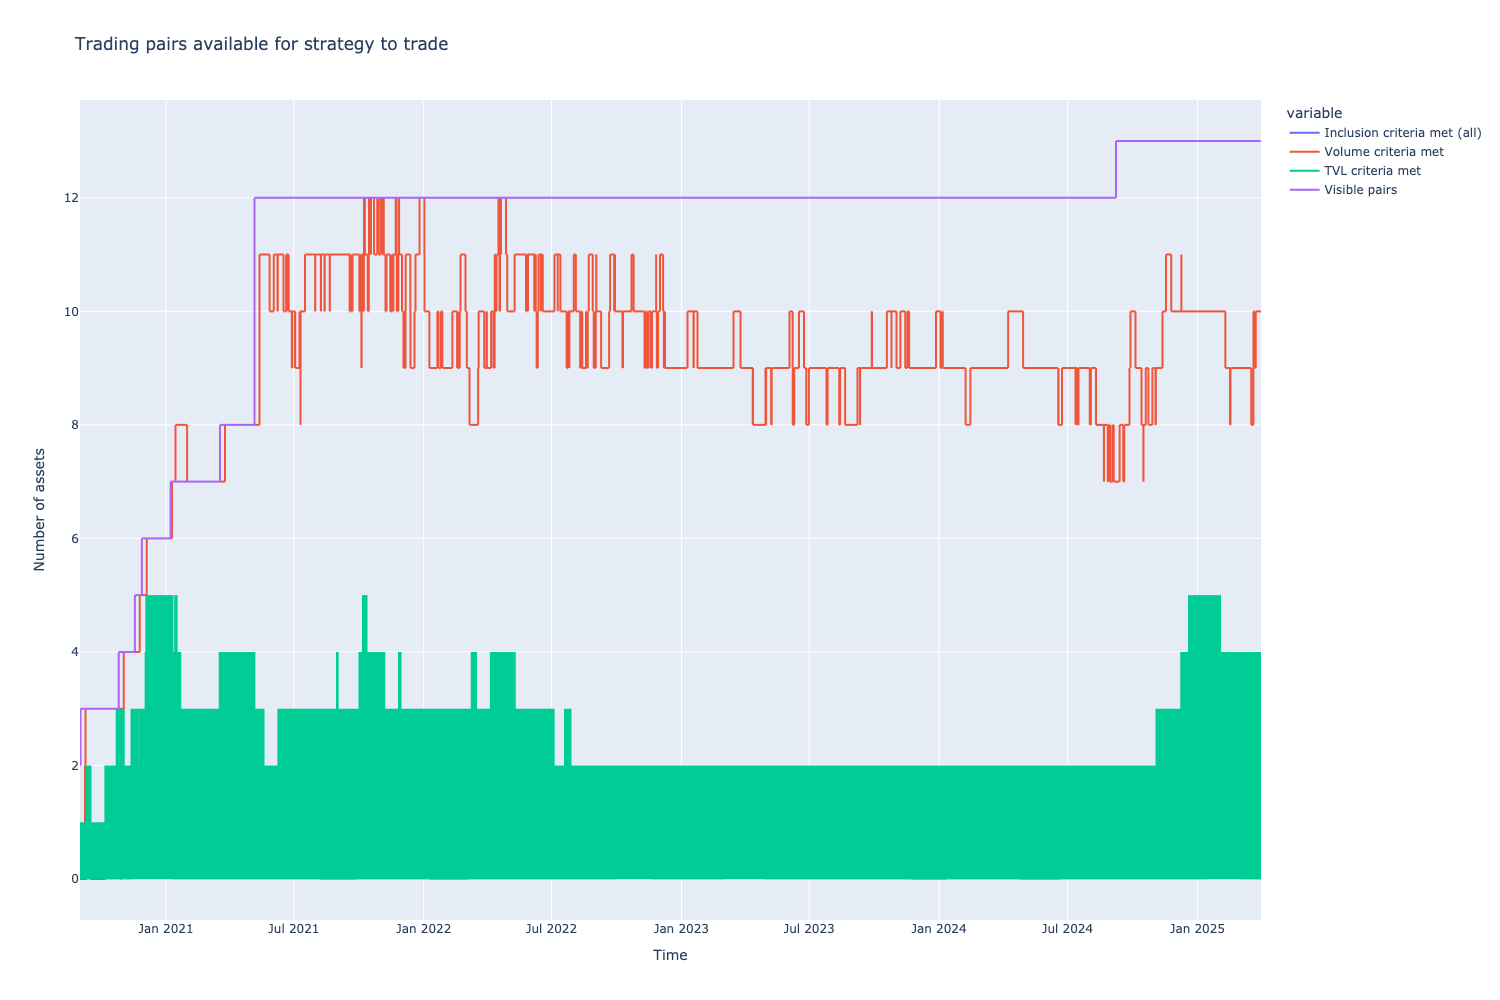

Inclusion criteria met (all)  Volume criteria met  \
2025-03-31 23:00:00                             2                 10.0   
2025-03-31 23:15:00                             0                 10.0   
2025-03-31 23:30:00                             0                 10.0   
2025-03-31 23:45:00                             0                 10.0   
2025-04-01 00:00:00                             2                 10.0   

                     TVL criteria met  Visible pairs  
2025-03-31 23:00:00                 4           13.0  
2025-03-31 23:15:00                 0           13.0  
2025-03-31 23:30:00                 0           13.0  
2025-03-31 23:45:00                 0           13.0  
2025-04-01 00:00:00                 4           13.0

In [25]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for strategy to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

# Price vs. ADX indicator

- Plot the indicator

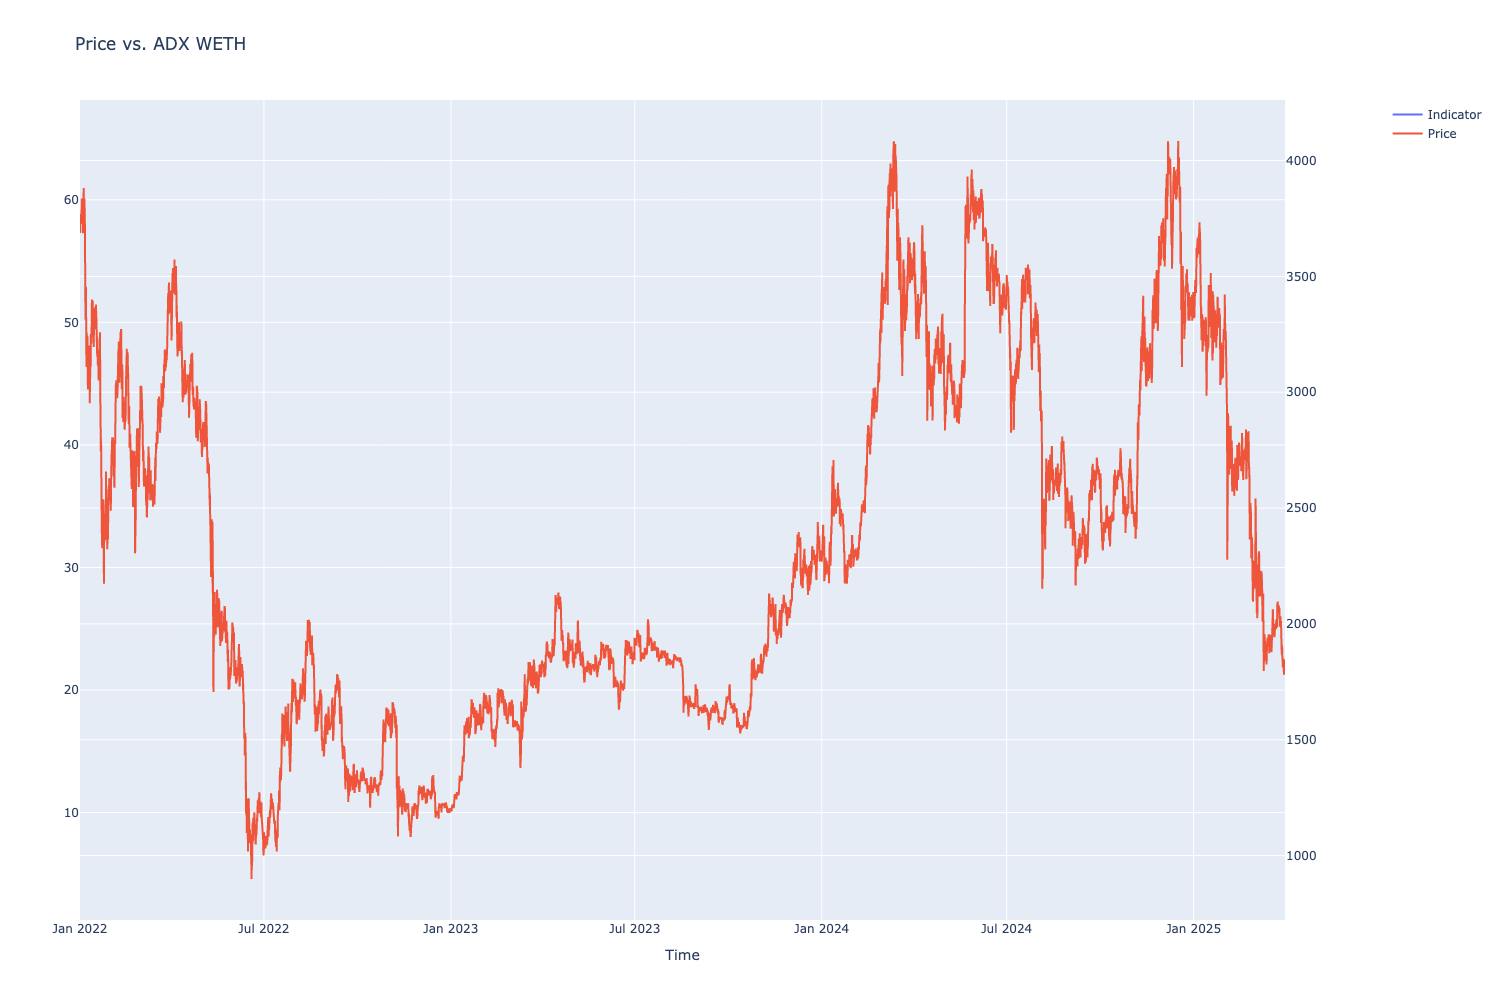

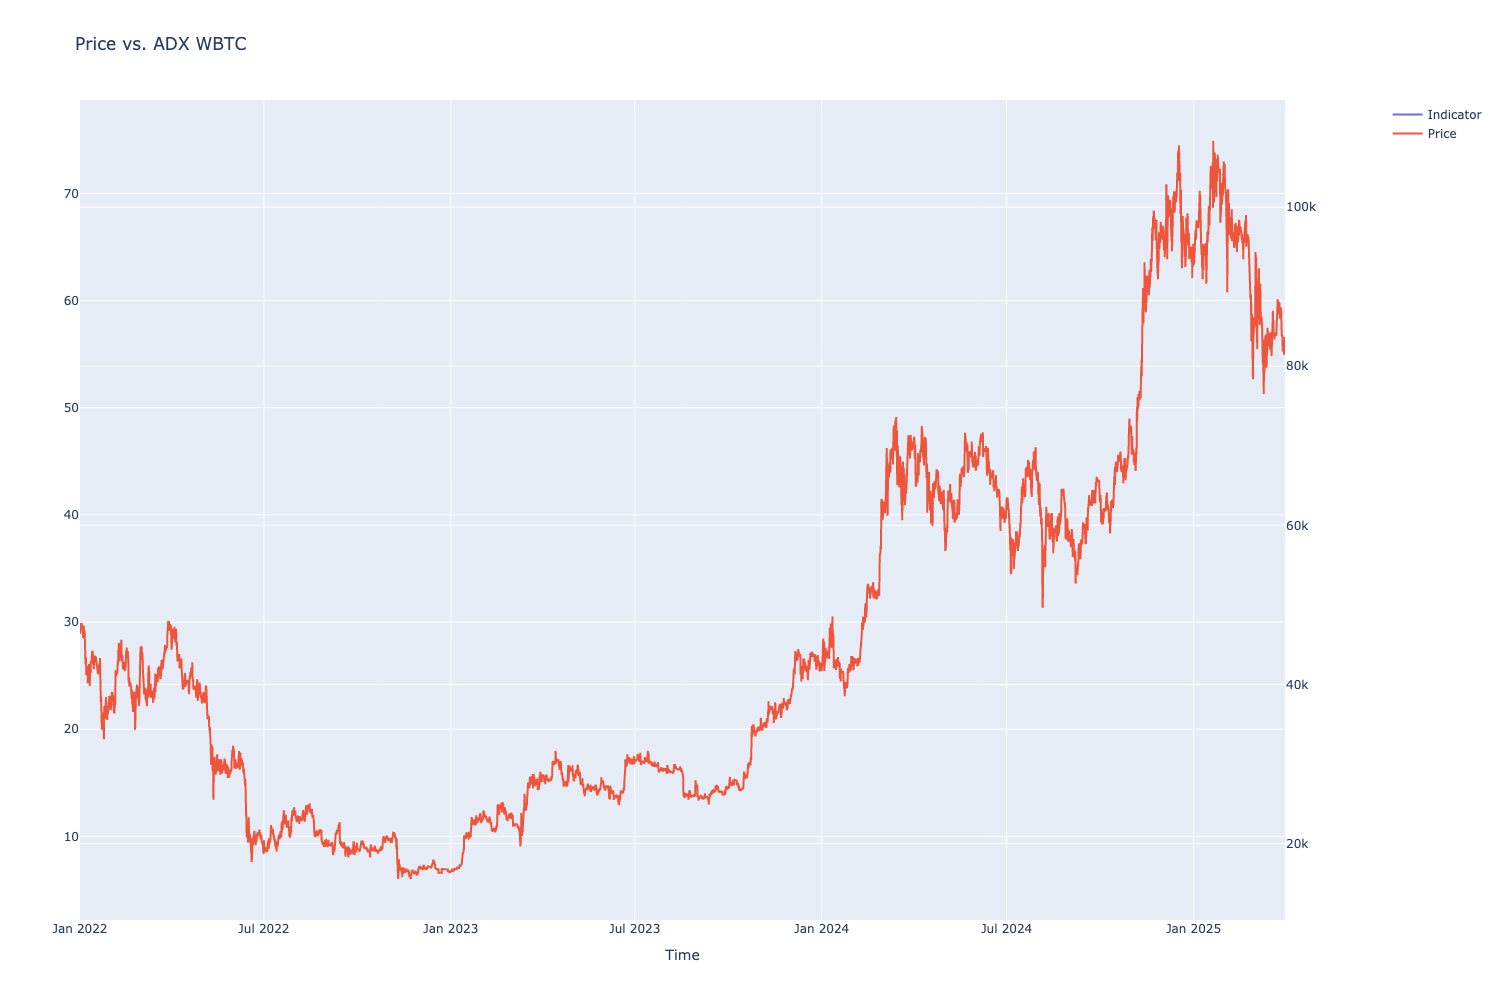

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

start = pd.Timestamp("2022-01-01")
#end = pd.Timestamp("2025-03-01")
end = pd.Timestamp("2025-04-01")

selected_assets = [
    strategy_universe.get_pair_by_human_description(s)
    for s in SUPPORTING_PAIRS
]

# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("daily_adx", pair=pair, column="DMP_14")    

    signal = signal.resample("1h").ffill()

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })


    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. ADX {pair.base.token_symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. volatility bin

- Plot the indicator

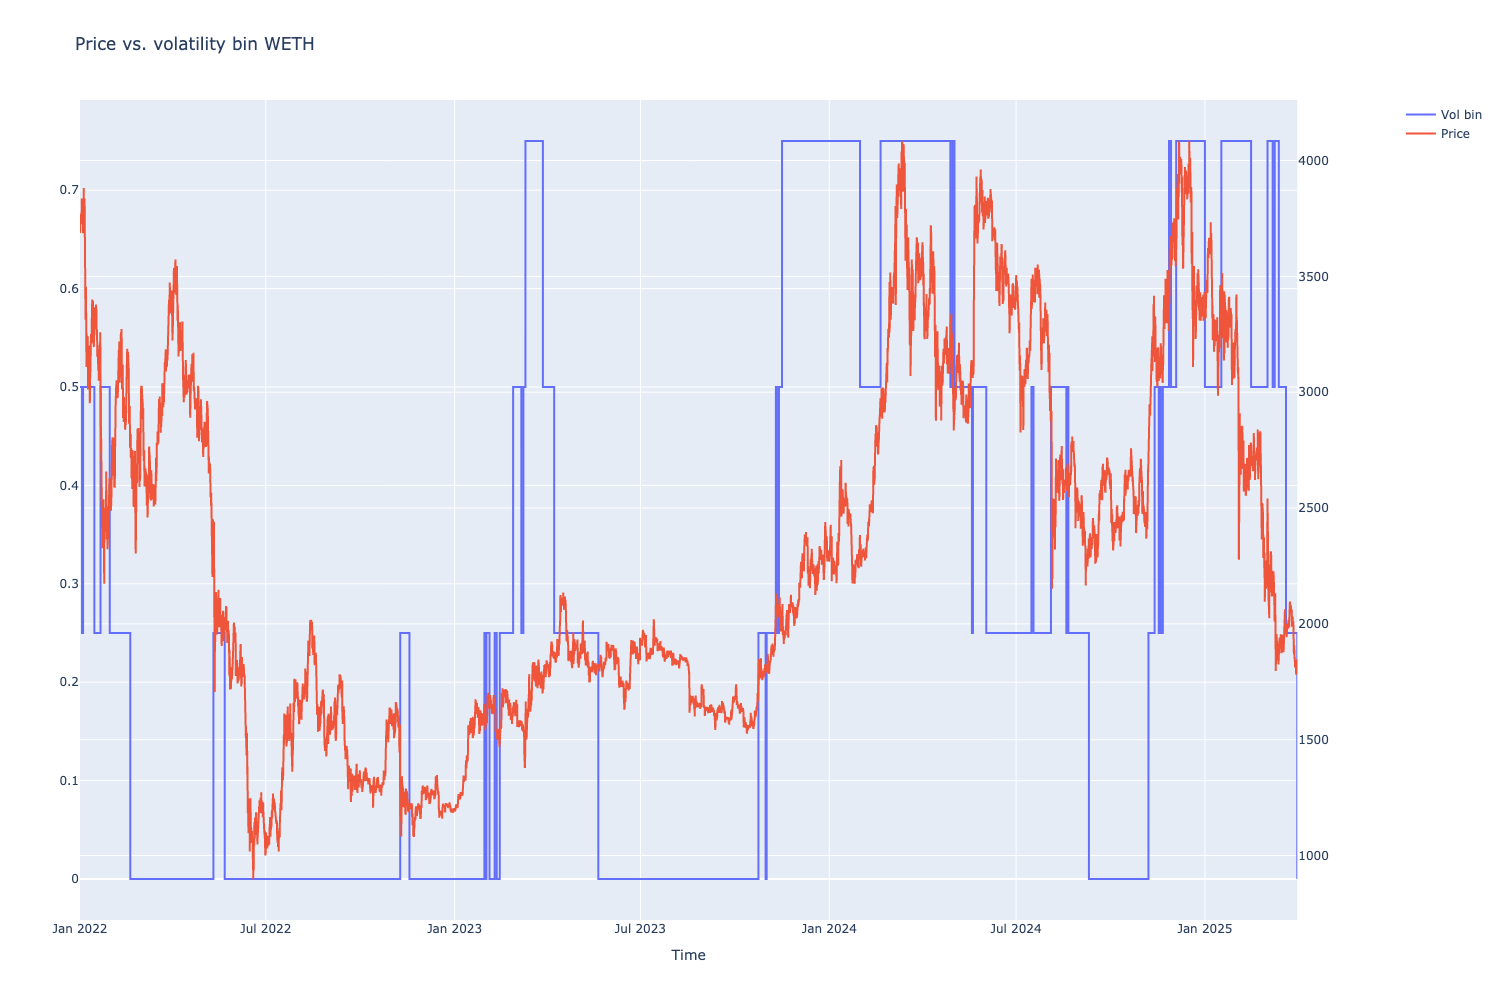

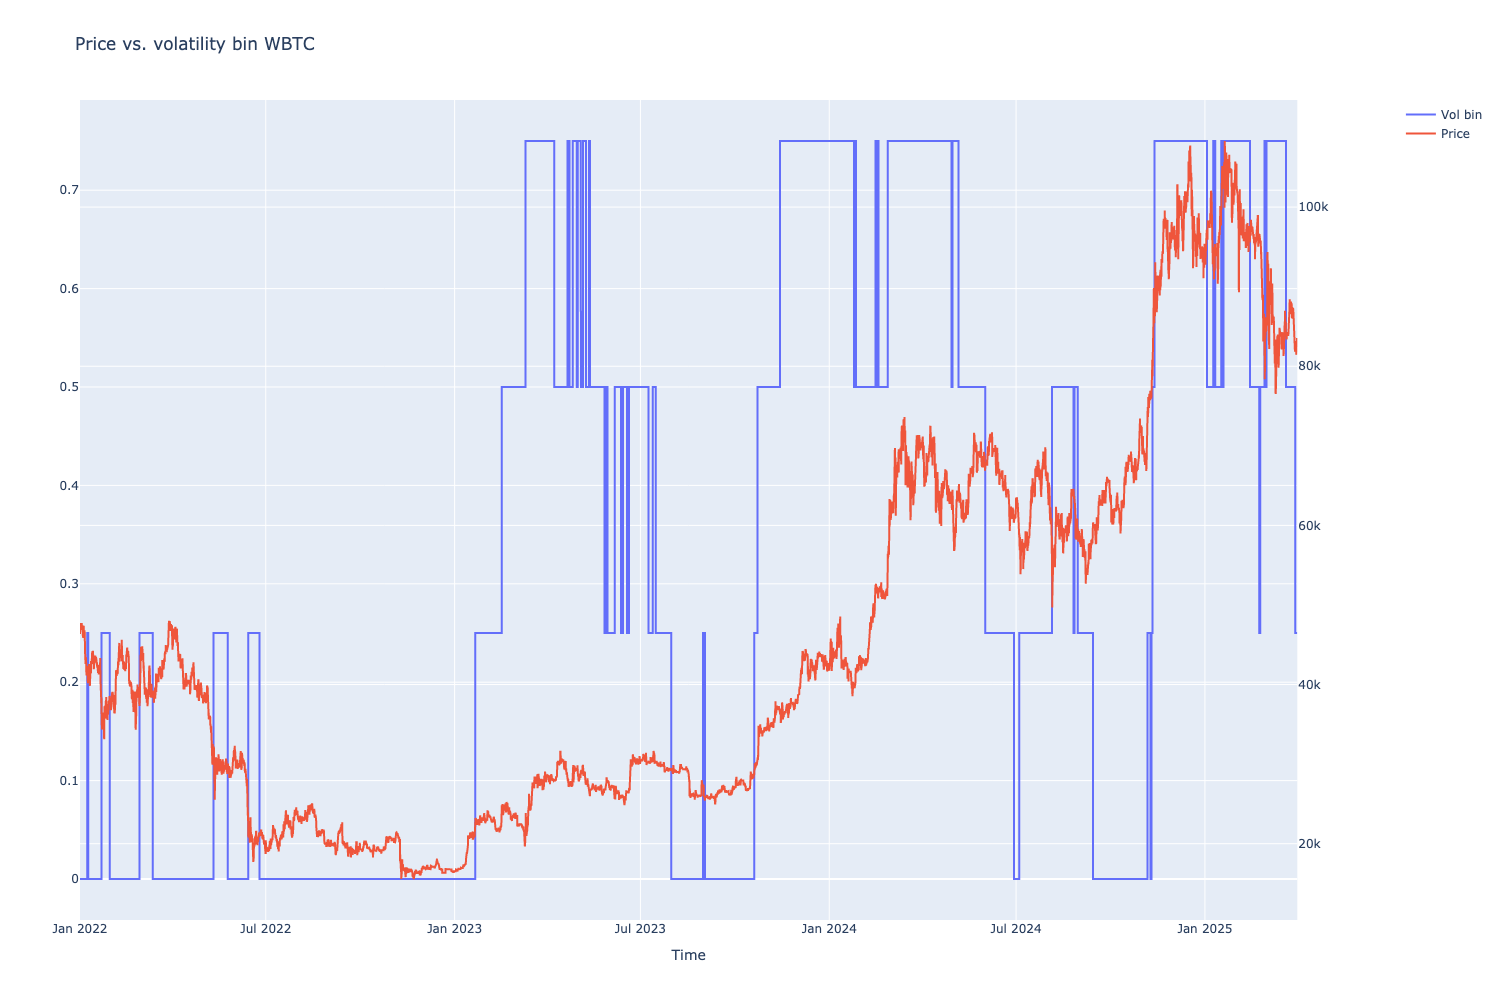

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_bin", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Vol bin"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. volatility bin {pair.base.token_symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. ROC indicator

- Plot the indicator

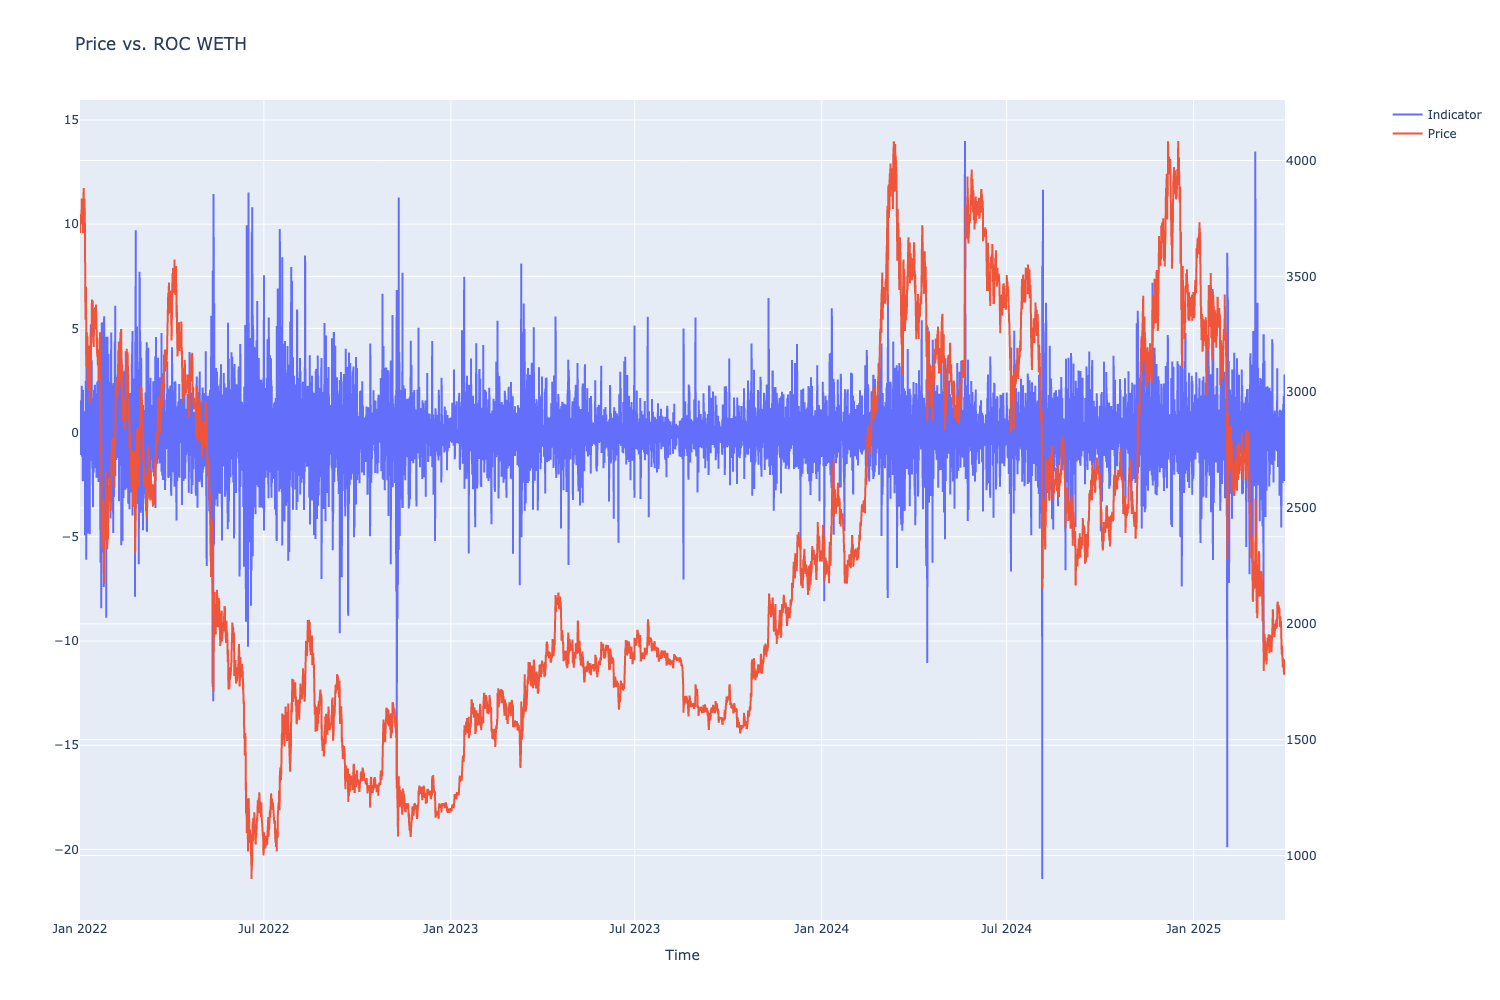

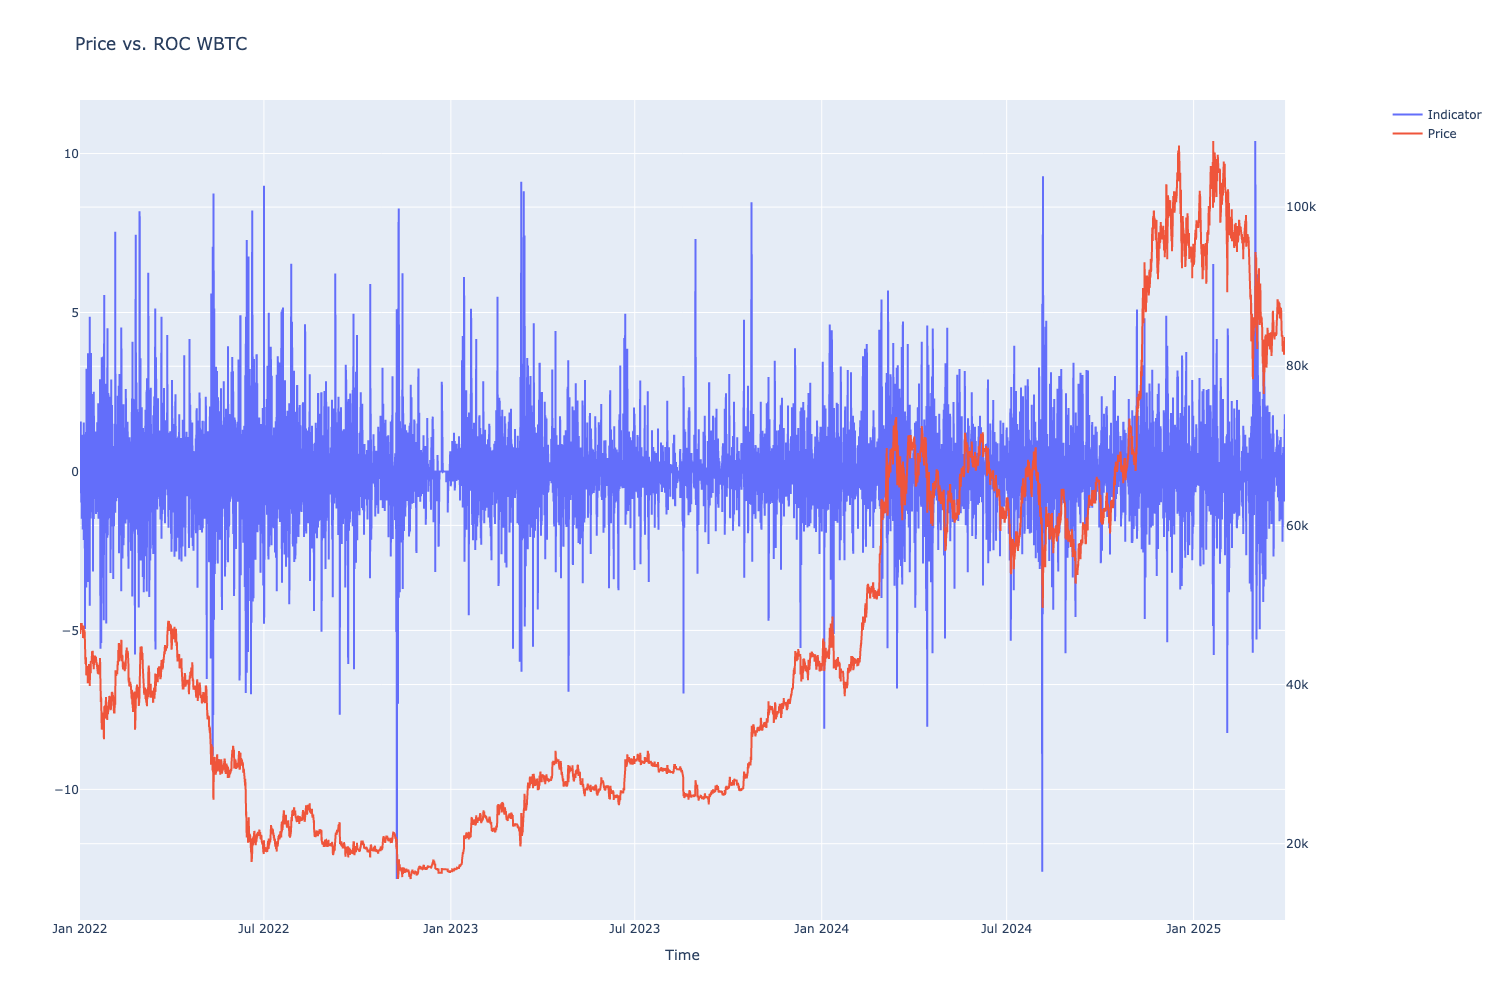

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("roc", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. ROC {pair.base.token_symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. breakout threshold vs. moving average filter

- Plot the indicator

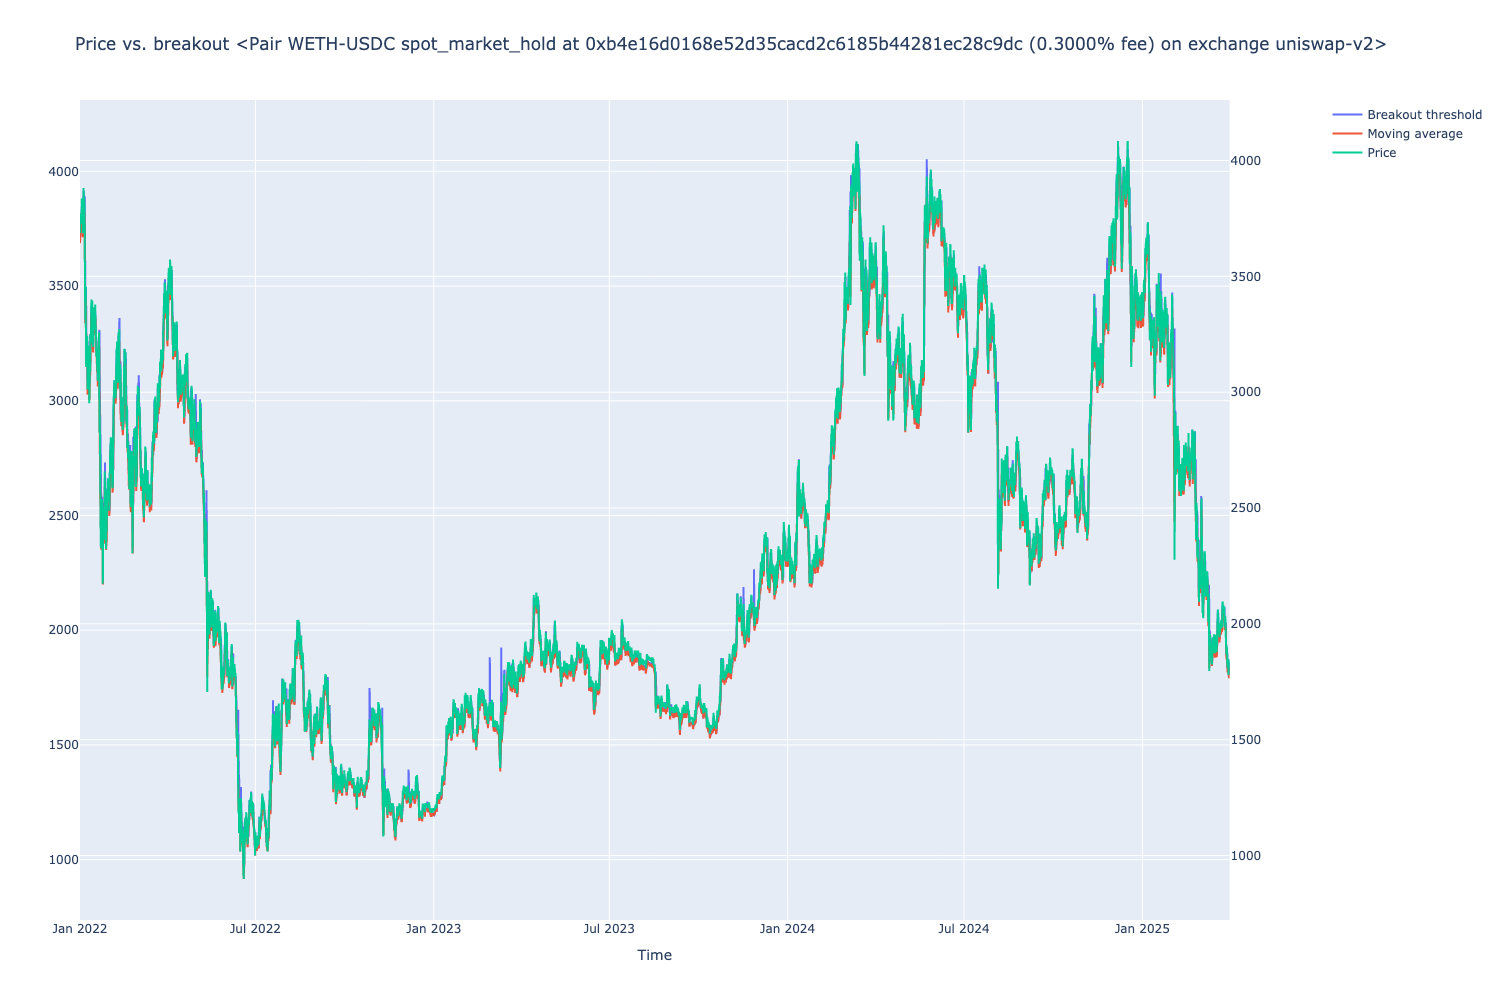

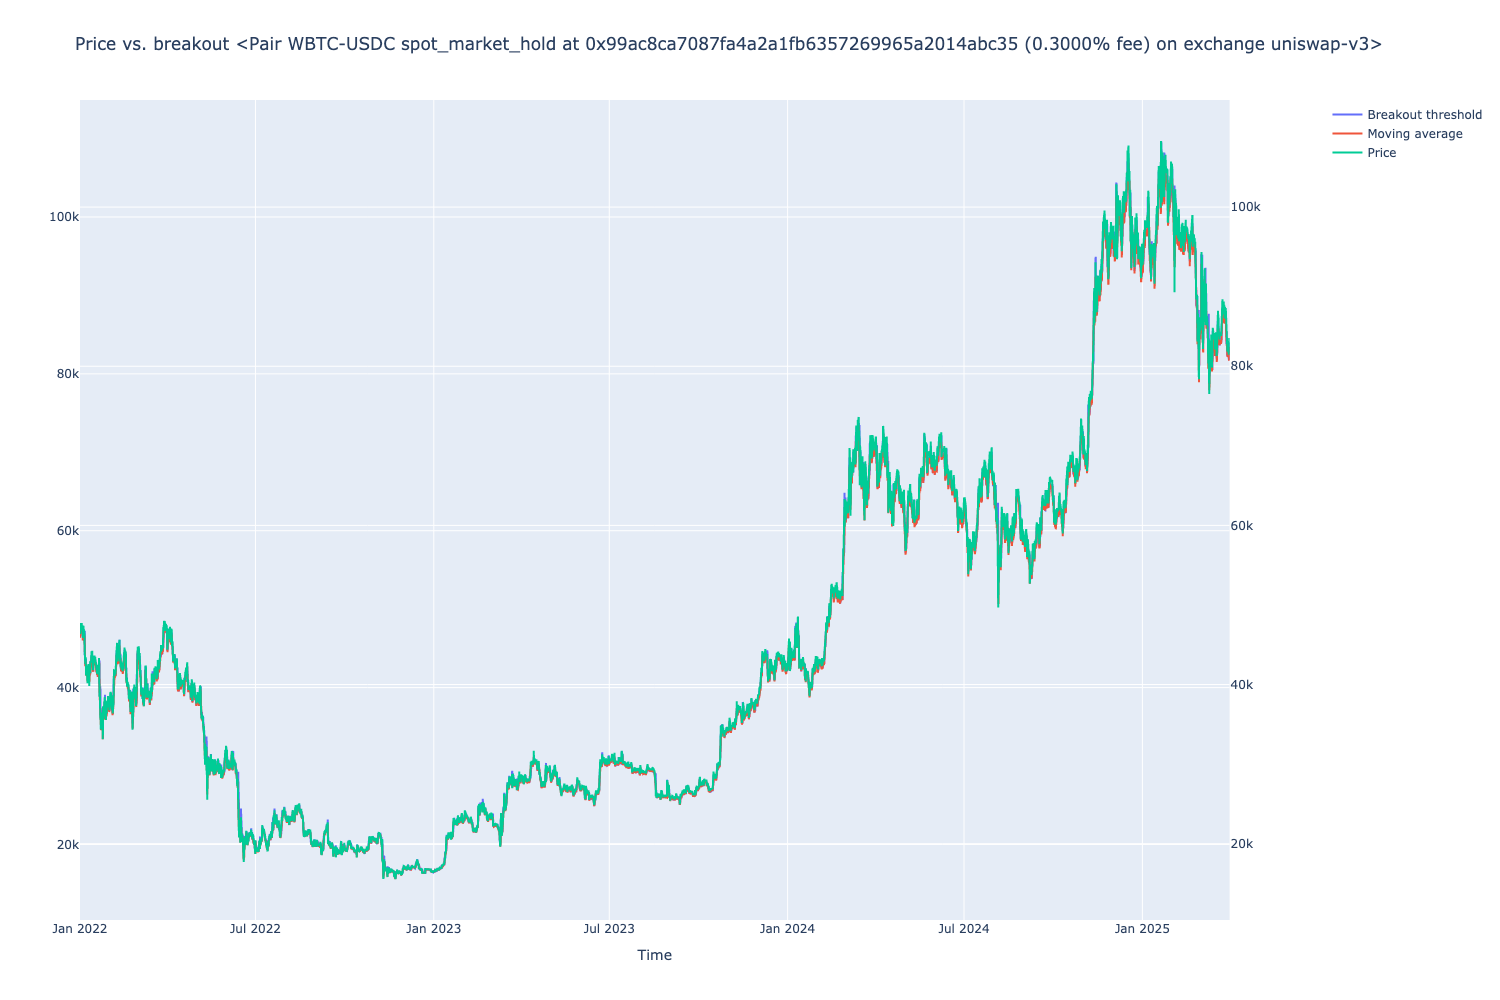

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("breakout_threshold", pair=pair)    
    moving_average = indicator_data.get_indicator_series("ema", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        "moving_average": moving_average,
    })

    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Breakout threshold"),
        secondary_y=False,        
    )


    fig.add_trace(
        go.Scatter(x=df.index, y=df["moving_average"], name="Moving average"),
        secondary_y=False,        
    )    

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. breakout {pair}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

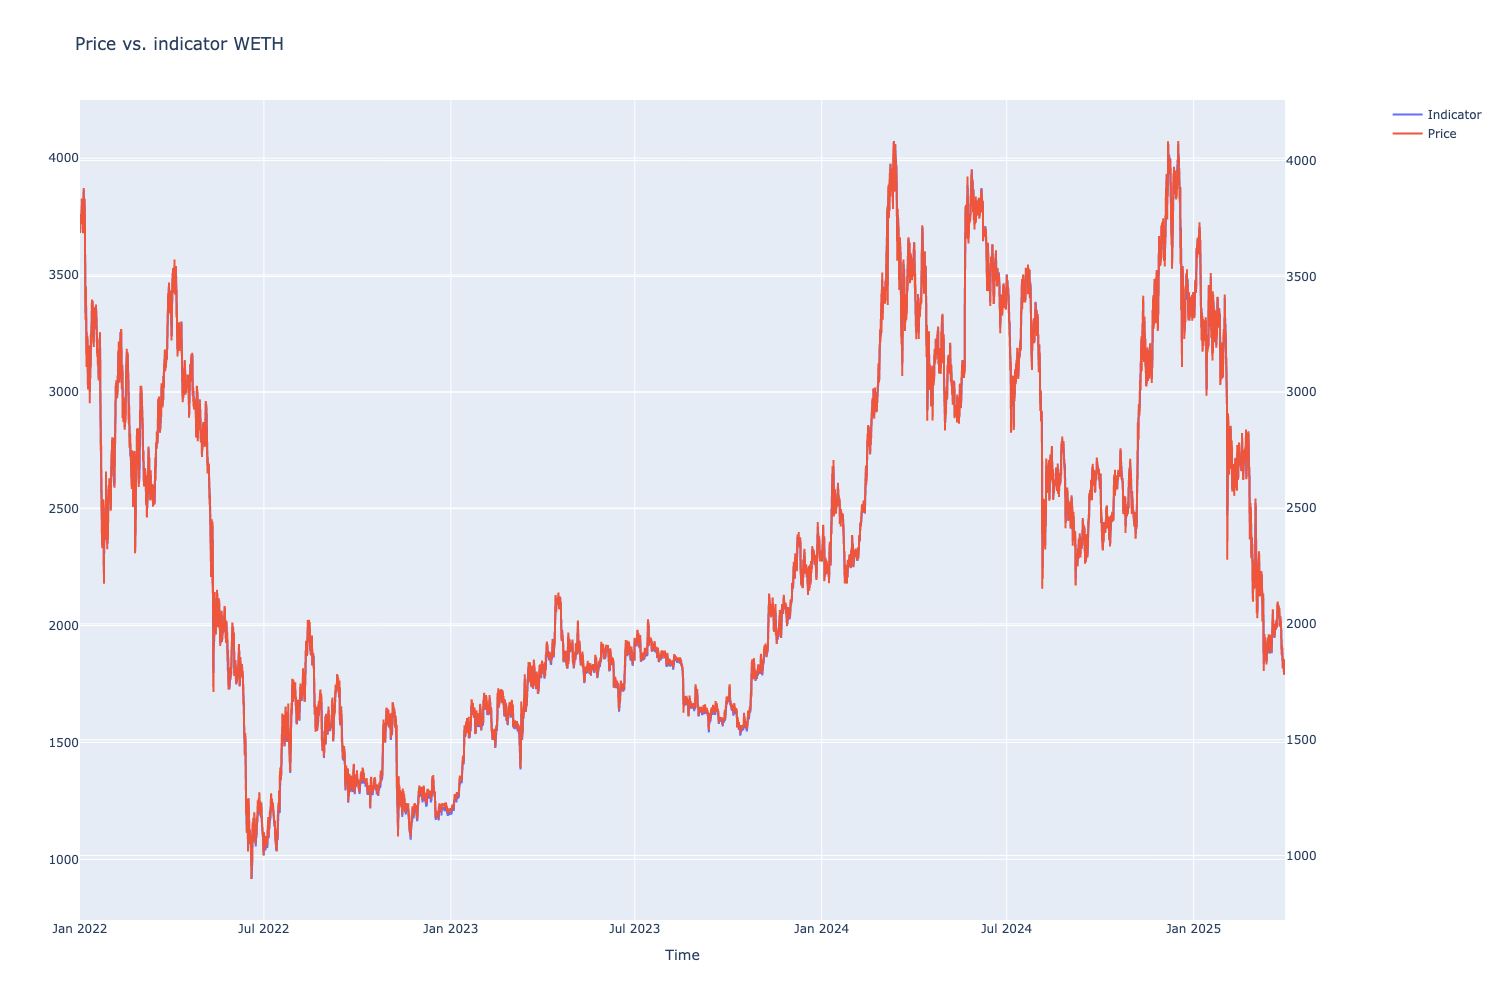

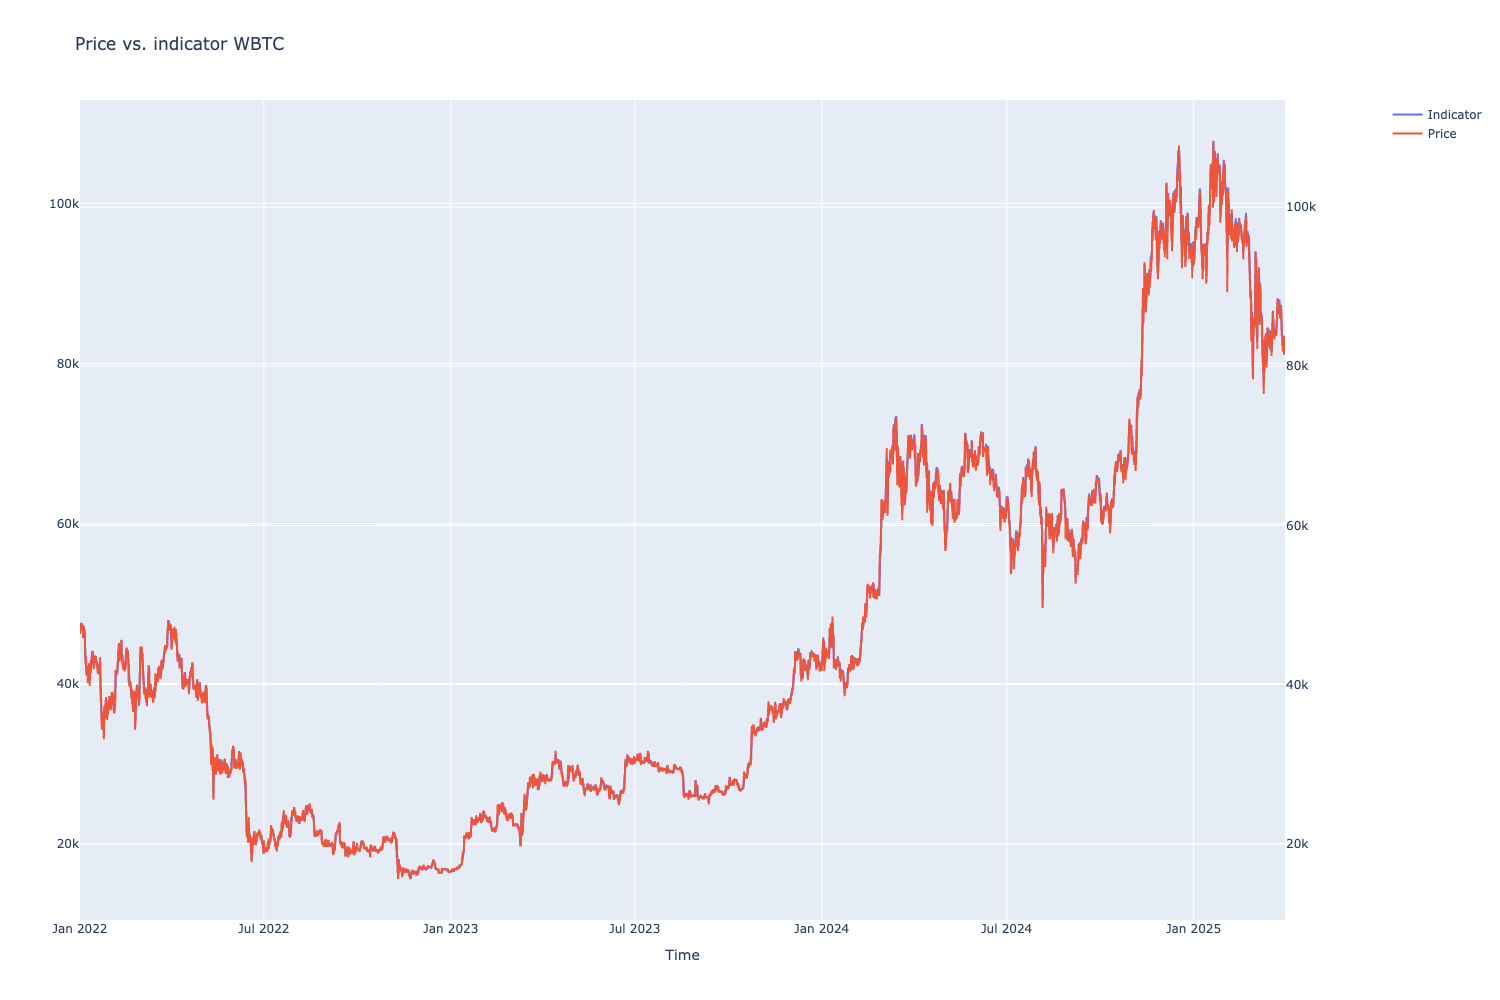

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("ema", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. indicator {pair.base.token_symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. signal

- Plot the indicator

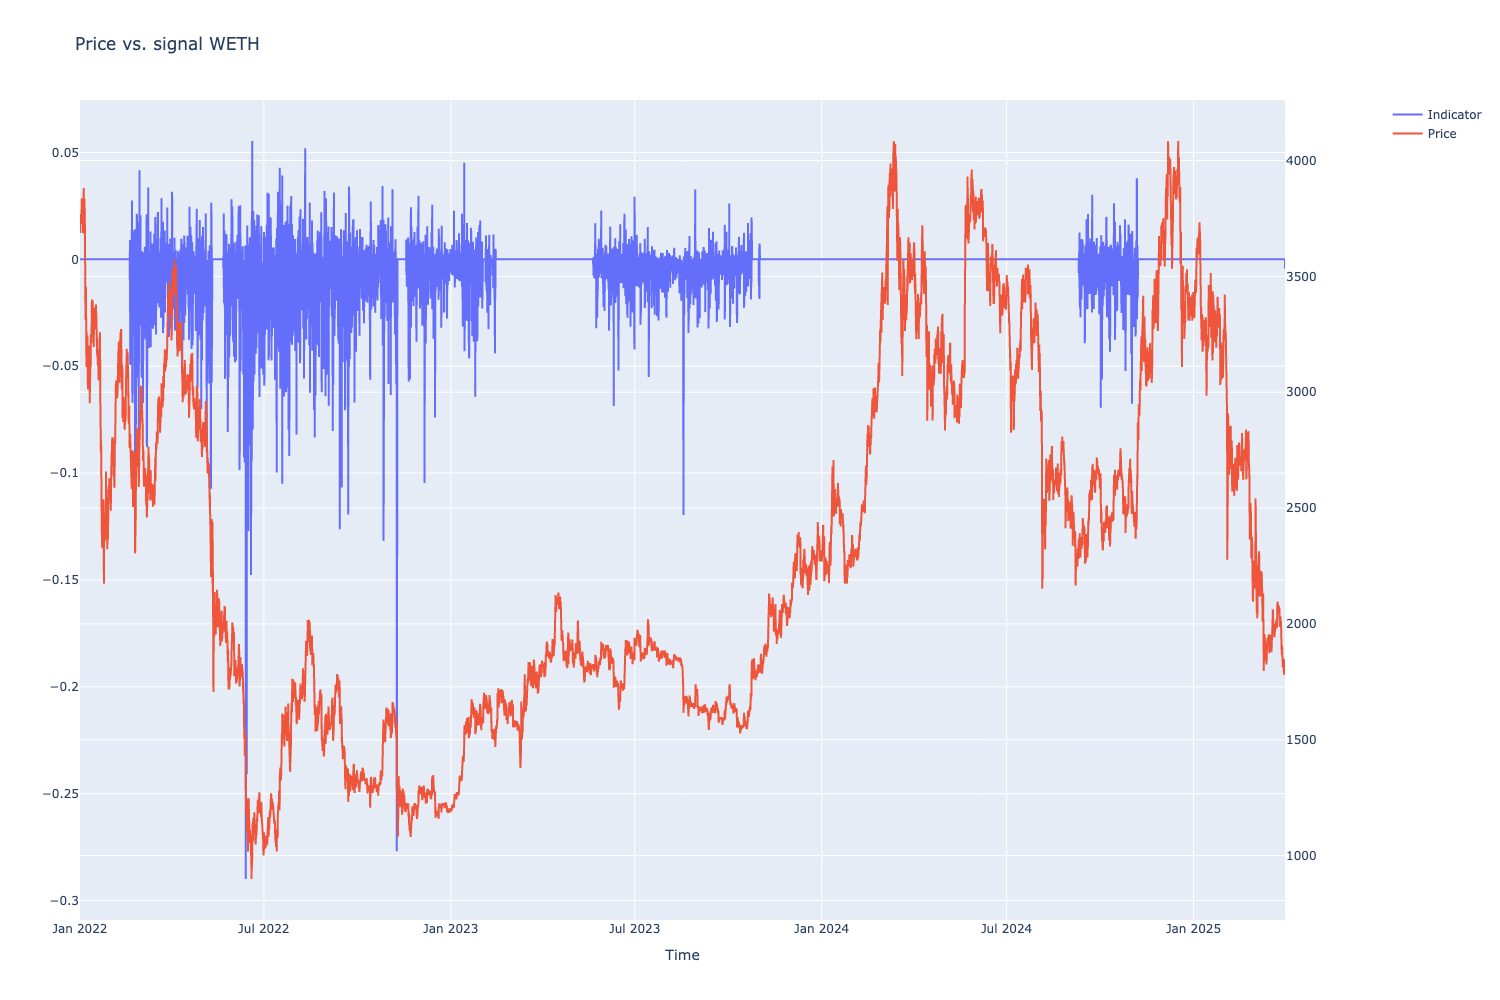

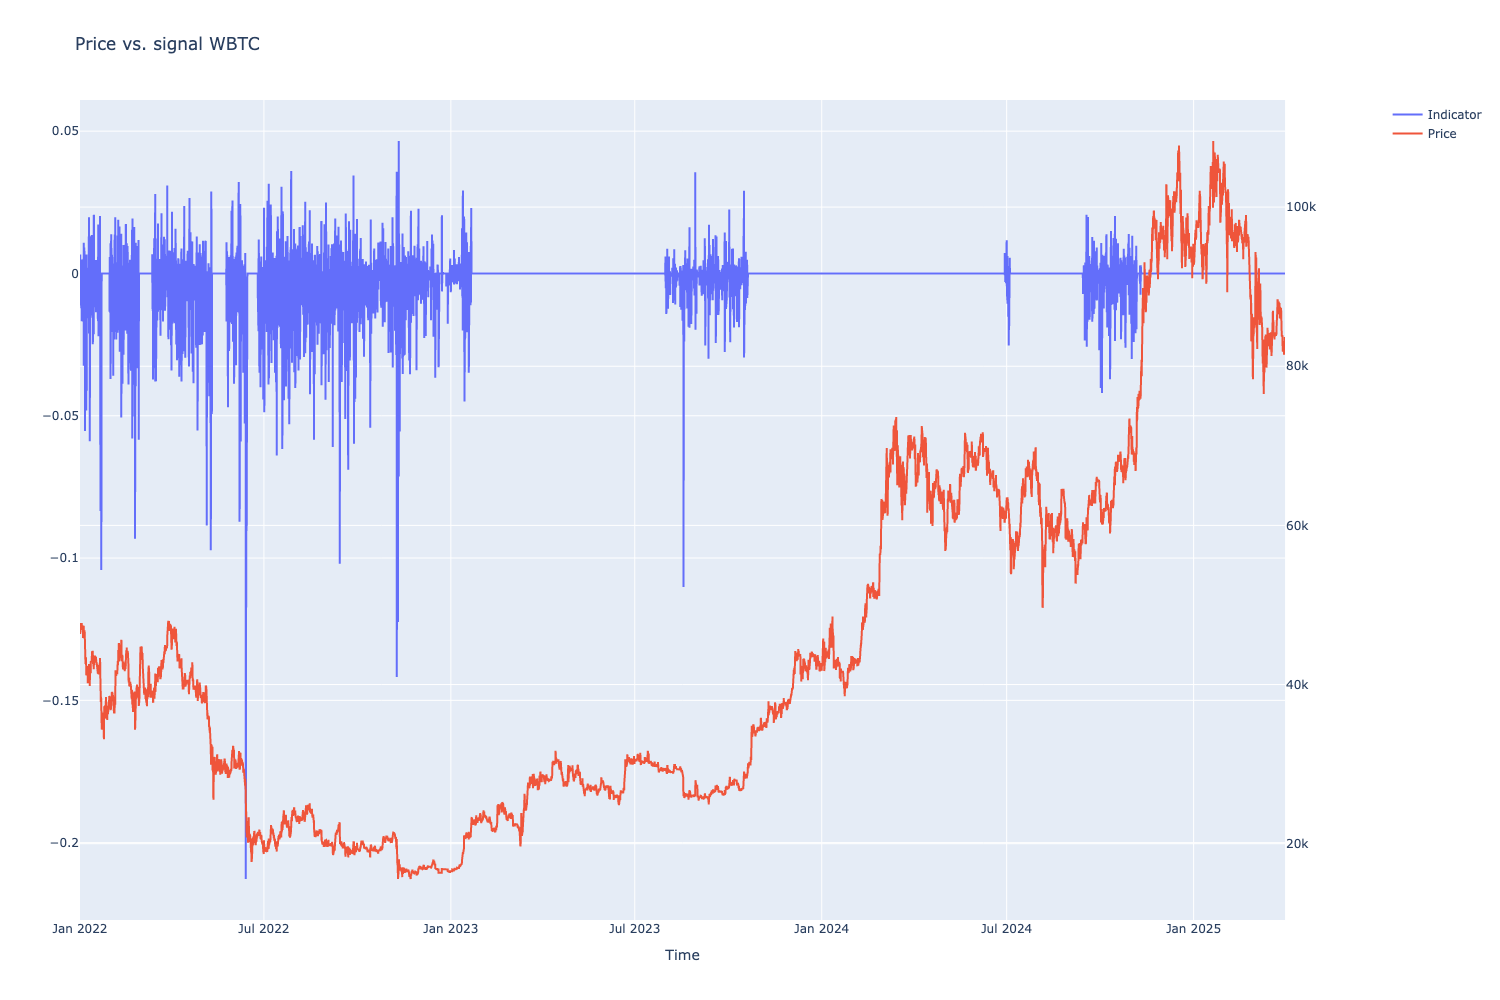

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TODO: Plotly refuses correctly to plot the third y-axis
for pair in selected_assets:
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("signal", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df = df.loc[start:end]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {pair.base.token_symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Strategy algorithm and backtest

- Describe out trading strategy as code

In [32]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe
    
    trades = []

    # Trade each of our pair individually.
    #
    # If any pair has open position,
    # do not try to rebalance, but hold that position to the end.
    #
   # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    if state.portfolio.get_total_equity() < 1000:
        # Stop backtesting after making tons of loss,
        # the strategy run failed
        return []
        
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
    )

    # Enable trailing stop loss after we reach the profit taking level
    #
    for position in state.portfolio.open_positions.values():
        if position.trailing_stop_loss_pct is None:
            close_price = indicators.get_price(position.pair)
            if close_price >= position.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                position.trailing_stop_loss_pct = parameters.trailing_stop_loss_pct                

    # Check breakout signal for each pair
    cash = position_manager.get_current_cash()
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)
        signal = indicators.get_indicator_value("signal", pair=pair)  # The ATR value at the time of close price
    
        # Check for open condition - is the price breaking out
        #
        if signal is not None and signal > 0:
            existing_position = position_manager.get_current_position_for_pair(pair)
            if existing_position is None:
                size_risk = size_risk_model.get_acceptable_size_for_buy(timestamp, pair, cash)
                if size_risk.accepted_size > parameters.min_position_size:
                    position_size = max(cash * parameters.allocation, size_risk.accepted_size) * 0.99
                    trades += position_manager.open_spot(
                        pair,
                        value=position_size,
                        stop_loss_pct=parameters.stop_loss_pct,             
                    )
                    cash -= position_size

    # Visualisations
    #
    if input.is_visualisation_enabled():
        visualisation = state.visualisation
        pass

    return trades  # Return the list of trades we made in this cycle



result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=Parameters.backtest_start,
    end_at=Parameters.backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")



Reading cached indicators atr, ema, roc, daily_price, daily_adx, volatility_bin, regime, tvl, tvl_ewm, tvl_inc…

Using indicator cache /Users/moo/.cache/indicators/ethereum_15m_15_2020-09-01-2025-04-01_ff


  0%|          | 0/144547200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 584 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against MATIC buy and hold

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_75297/4031153188.py:11: DeprecationWarning:

Pass parameter state instead of portfolio_statistics



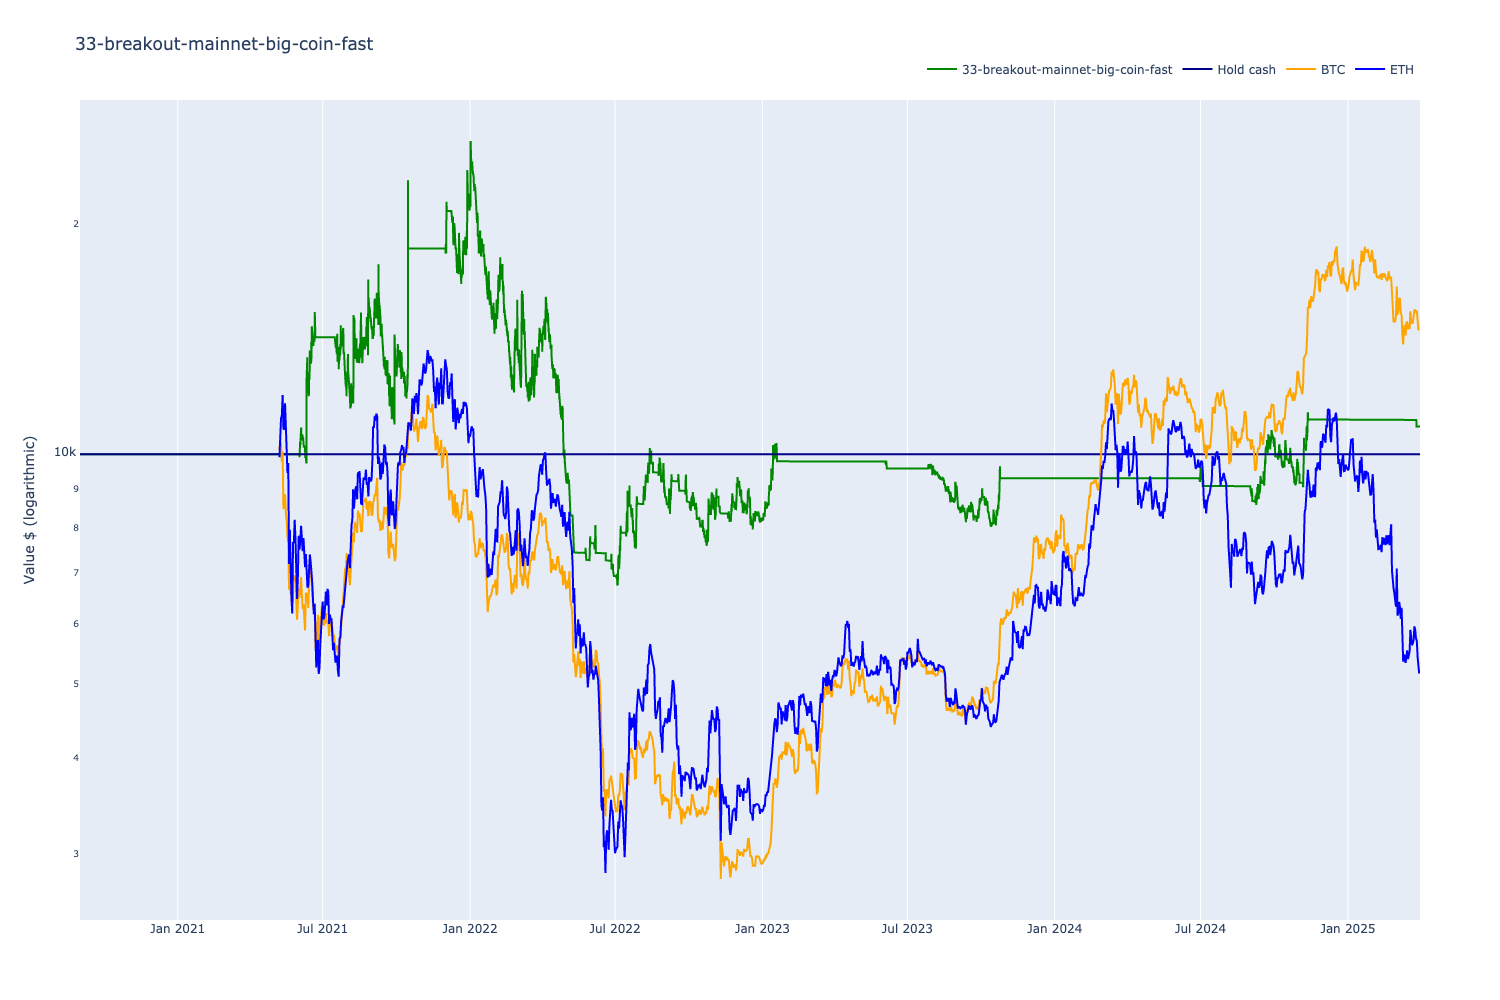

In [33]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
)

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

In [34]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

try:
    df = compare_strategy_backtest_to_multiple_assets(
        state,
        strategy_universe,
        display=True,
    )
    display(df)
except Exception as e:
    print(e)

Strategy                  BTC  \
Start Period                        2020-09-01           2020-09-01   
End Period                          2025-03-31           2025-03-31   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           34.0%                84.0%   
Cumulative Return                        8.73%              118.01%   
CAGR﹪                                    1.27%               12.46%   
Sharpe                                    0.26                 0.59   
Prob. Sharpe Ratio                      72.01%               89.56%   
Smart Sharpe                              0.25                 0.56   
Sortino                                   0.54                 0.86   
Smart Sortino                             0.51                 0.82   
Sortino/√2                                0.38                 0.61   
Smart Sortino/√2                          0.36                 0.58   
Omega                                     1.08                 1.08   
Max Drawdown                           -72.75%              -76.74%   
Longest DD Days                           1185                  846   
Volatility (ann.)                       49.32%               51.92%   
Calmar                                    0.02                 0.16   
Skew                                      7.38                 0.03   
Kurtosis                                 111.2                 4.56   
Expected Daily                           0.01%                0.05%   
Expected Monthly                         0.15%                1.43%   
Expected Yearly                           1.4%               13.87%   
Kelly Criterion                          3.25%                8.77%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -4.21%               -4.39%   
Expected Shortfall (cVaR)               -4.21%               -4.39%   
Max Consecutive Wins                         7                    9   
Max Consecutive Losses                      14                    8   
Gain/Pain Ratio                           0.08                  0.1   
Gain/Pain (1M)                            0.37                 0.58   
Payoff Ratio                               1.5                 1.18   
Profit Factor                             1.08                  1.1   
Common Sense Ratio                        1.06                 1.19   
CPC Index                                 0.68                 0.66   
Tail Ratio                                0.98                 1.08   
Outlier Win Ratio                        14.33                 5.42   
Outlier Loss Ratio                        2.57                 3.32   
MTD                                      -2.1%               -2.81%   
3M                                       -2.1%               -12.0%   
6M                                       3.56%               25.21%   
YTD                                      -2.1%              -11.06%   
1Y                                      16.92%               17.64%   
3Y (ann.)                                3.28%               18.72%   
5Y (ann.)                                1.27%               12.46%   
10Y (ann.)                               1.27%               12.46%   
All-time (ann.)                          1.27%               12.46%   
Best Day                                 48.8%               15.34%   
Worst Day                              -12.65%               -15.4%   
Best Month                              46.26%                50.9%   
Worst Month                            -33.99%              -36.53%   
Best Year                              111.27%              156.73%   
Worst Year                             -61.14%              -65.18%   
Avg. Drawdown                          -18.17%              -10.08%   
Avg. Drawdown Days                         148                   52   
Recovery Factor                           0.81                

# Trading statistics

- Display summare about made trades

In [35]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Trading pair profitability analysis

In [36]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Examine trades across all pairs

- Plot all trades on timeline

id    profit ticker          size  color  plot_size
timestamp                                                               
2021-06-02 03:15:00   1  0.055026   BOND   9900.000000  green   6.037504
2021-06-04 22:15:00   2 -0.029342   BOND  10439.313836    red   6.257452
2021-06-08 18:15:00   3 -0.031591   BOND  10136.070185    red   6.133781
2021-06-10 01:15:00   4  0.293784   BOND   9819.058732  green   6.004494
2021-06-11 10:15:00   5 -0.031478   BOND  12674.889481    red   7.169184

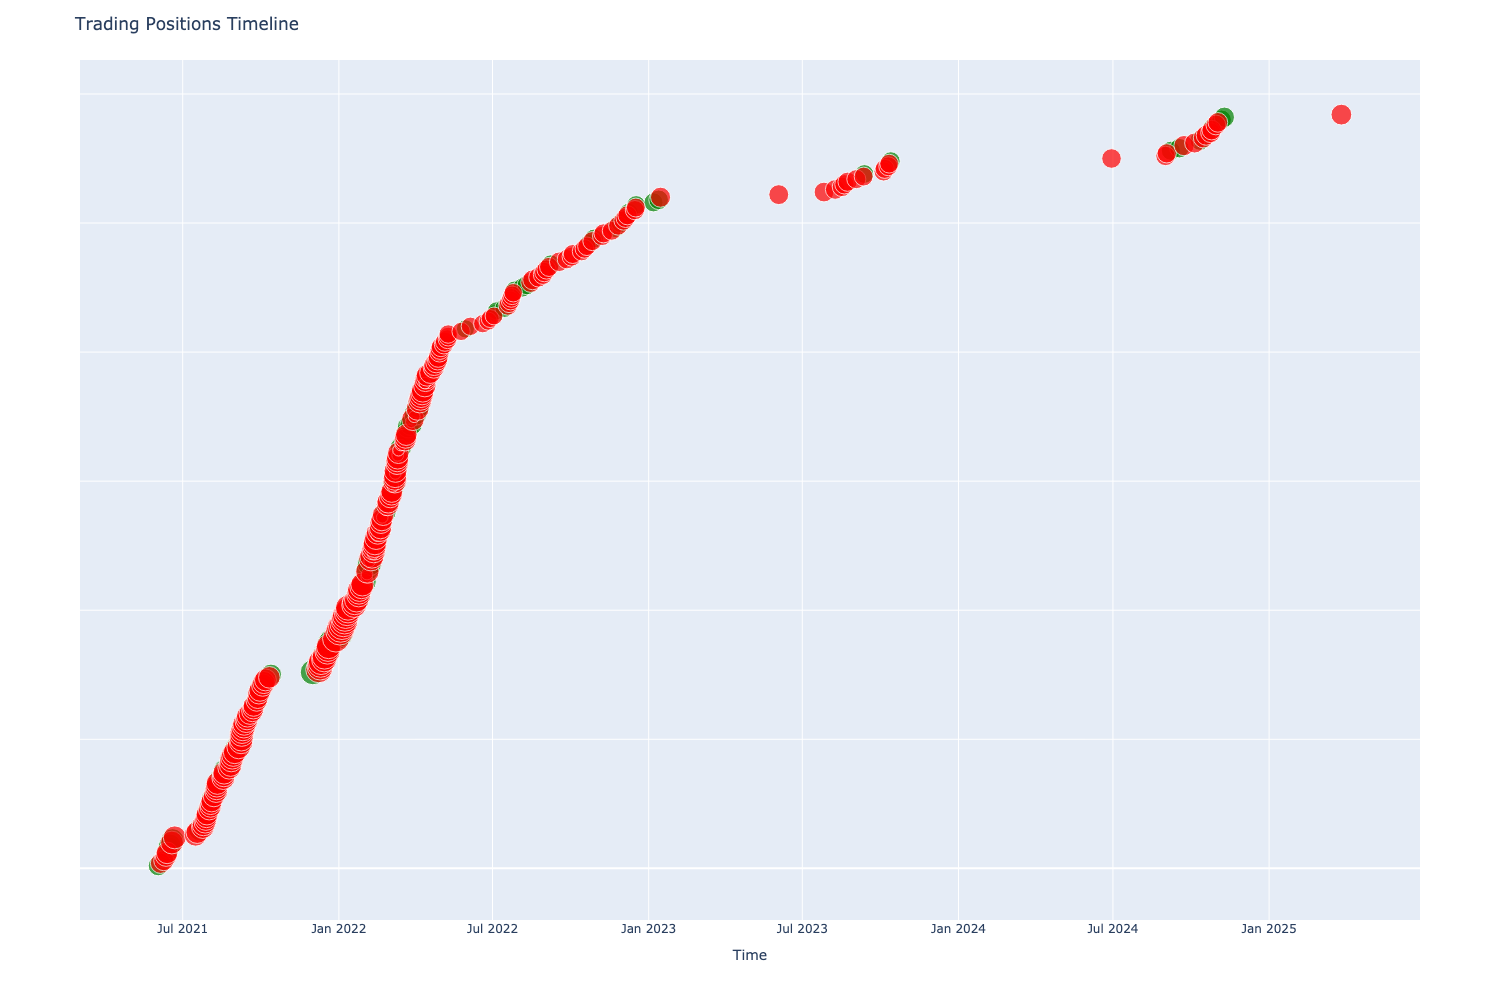

In [37]:
# https://plotly.com/python/bubble-charts/

positions = [{
    "id": p.position_id,
    "timestamp": p.opened_at,
    "profit": p.get_realised_profit_percent(),
    "ticker": p.pair.base.token_symbol,
    "size": p.get_value_at_open(),
 } for p in state.portfolio.closed_positions.values()
]

df = pd.DataFrame(positions)
df = df.set_index("timestamp")

df['color'] = df['profit'].apply(lambda x: 'green' if x > 0 else 'red')  # Green for profit, red for loss
df['plot_size'] = 2 + (10 * df["size"] / df['size'].max())

display(df.head(5))

# Create scatter plot
fig = px.scatter(
    df,
    x=df.index,
    y=df["id"],
    size='plot_size',
    color='color',
    color_discrete_map={'green': 'green', 'red': 'red'},
)

# Update layout for better visualization
fig.update_layout(
    title='Trading Positions Timeline',
    xaxis_title='Time',
    yaxis=dict(showticklabels=False, title=''),  # Hide Y-axis
    showlegend=False,
    hovermode='x unified'
)

# Show plot
fig.show()



# Examine single pair

- Show trades taken against a single pair

We have total 194 trades on <Pair WETH-USDC spot_market_hold at 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 (0.0500% fee) on exchange uniswap-v3>


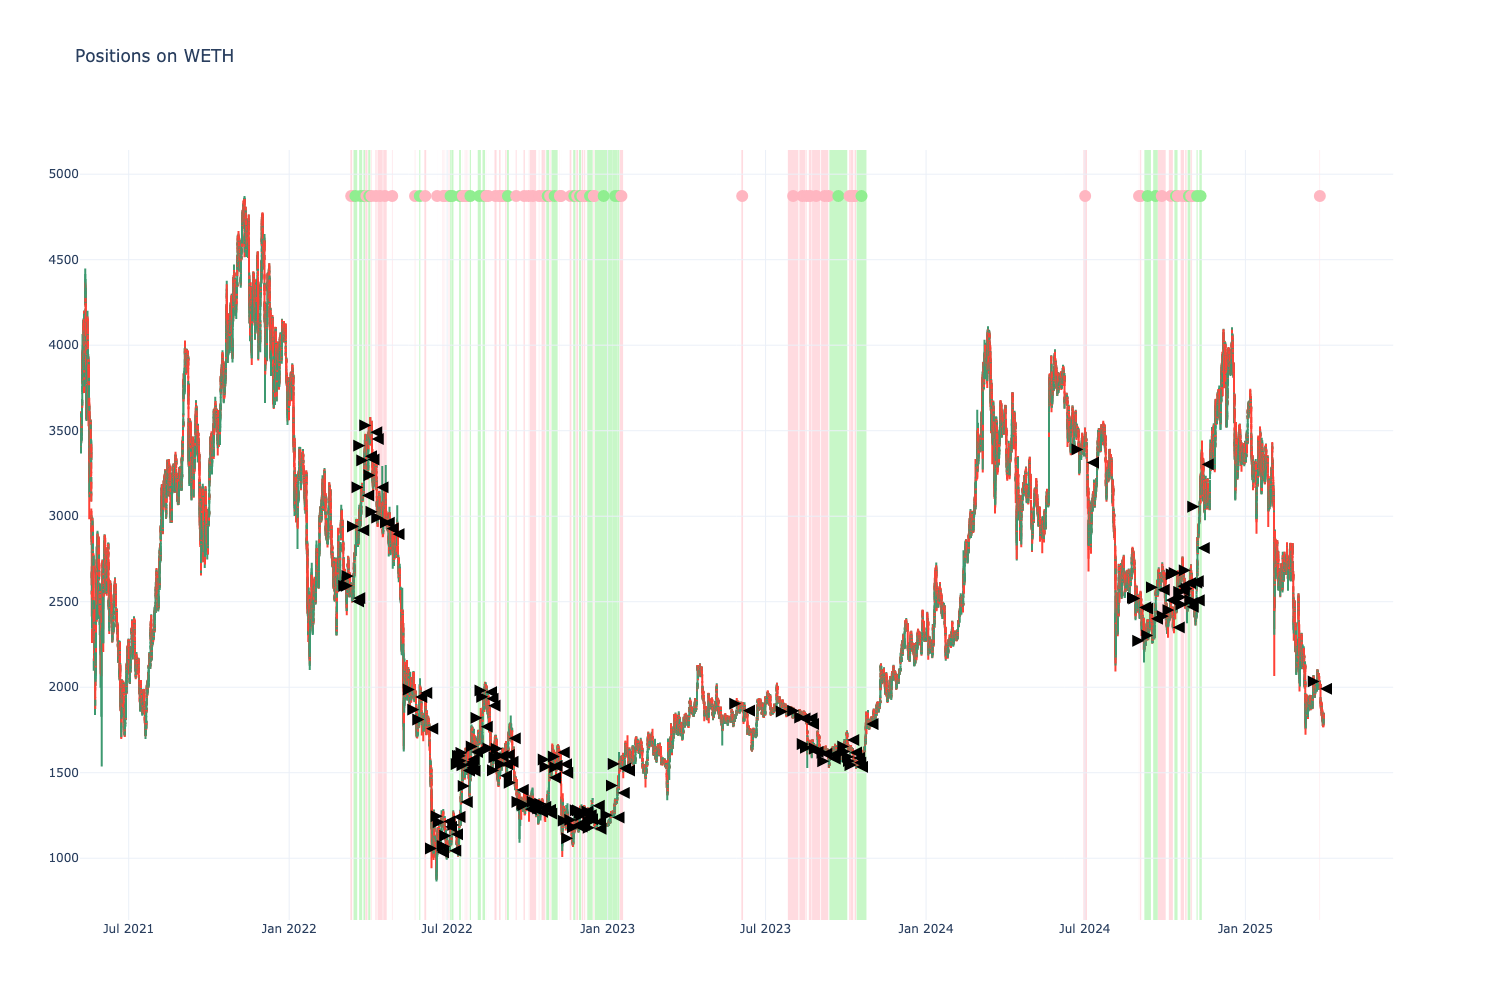

In [38]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

pair = strategy_universe.get_pair_by_human_description(
    (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005)
)

all_trades = [t for t in state.portfolio.get_all_trades() if t.pair == pair]
print(f"We have total {len(all_trades)} trades on {pair}")

#start = datetime.datetime(2022, 6, 5)
#end = datetime.datetime(2022, 8, 12)
start = None
end = None

signal = indicator_data.get_indicator_series("atr", pair=pair)

figure = visualise_single_pair_positions_with_duration_and_slippage(
    state=state,
    candles=strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id),
    pair_id=pair.internal_id,
    execution_context=notebook_execution_context,
    title=f"Positions on {pair.base.token_symbol}",
    start_at=start,
    end_at=end,
    technical_indicators=True,
)


figure.show()